In [6]:
# Updated image captioning training script
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence, to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Dense, LSTM, Embedding, Dropout,
                                     concatenate, Reshape, add)
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
from textwrap import wrap
import warnings
warnings.filterwarnings('ignore')

# ---------- USER CONFIG ----------
image_path = '../15k/Images'      # update as needed
captions_file = './15k/captions.txt'  # update as needed
img_size = 224
BATCH_SIZE = 64
EMBED_DIM = 256
LSTM_UNITS = 256
EPOCHS = 50
# ---------------------------------

# Utility: read captions file robustly (allow CSV or space/tab separated "image caption" pairs)
def load_captions(path):
    # try common formats
    if path.lower().endswith('.csv') or ',' in open(path, 'r', encoding='utf-8').read(4096):
        df = pd.read_csv(path, sep=None, engine='python', header=None, names=['image', 'caption'])
    else:
        # fallback: whitespace split first token is image id, rest is caption
        rows = []
        with open(path, 'r', encoding='utf-8') as f:
            for line in f:
                line = line.strip()
                if not line:
                    continue
                parts = line.split()
                image = parts[0]
                caption = " ".join(parts[1:]) if len(parts) > 1 else ""
                rows.append((image, caption))
        df = pd.DataFrame(rows, columns=['image', 'caption'])
    return df

# 1) Load captions
data = load_captions(captions_file)
# Drop empties, duplicates
data['caption'] = data['caption'].astype(str)
data = data[data['caption'].str.strip() != ""].reset_index(drop=True)

# Basic display helper (relies on load_img and image_path)
def readImage(path, img_size=224):
    img = load_img(path, color_mode='rgb', target_size=(img_size, img_size))
    img = img_to_array(img) / 255.0
    return img

def display_images(temp_df, n_images=9):
    temp_df = temp_df.reset_index(drop=True)
    n_show = min(len(temp_df), n_images)
    cols = int(np.ceil(np.sqrt(n_show)))
    plt.figure(figsize=(cols * 4, cols * 4))
    for i in range(n_show):
        plt.subplot(cols, cols, i + 1)
        img_file = os.path.join(image_path, temp_df.loc[i, 'image'])
        if not os.path.exists(img_file):
            plt.title("Missing: " + temp_df.loc[i, 'image'])
            plt.axis('off')
            continue
        image = readImage(img_file, img_size)
        plt.imshow(image)
        plt.title("\n".join(wrap(temp_df.loc[i, 'caption'], 30)))
        plt.axis('off')
    plt.show()

# 2) Text preprocessing
def preprocess_captions(df, caption_col='caption'):
    caps = df.copy()
    caps[caption_col] = caps[caption_col].str.lower()
    caps[caption_col] = caps[caption_col].str.replace("[^a-z\s]", " ", regex=True)
    caps[caption_col] = caps[caption_col].str.replace("\s+", " ", regex=True).str.strip()
    # remove single-letter tokens
    caps[caption_col] = caps[caption_col].apply(lambda s: " ".join([w for w in s.split() if len(w) > 1]))
    caps[caption_col] = "startseq " + caps[caption_col] + " endseq"
    return caps

data = preprocess_captions(data)
captions = data['caption'].tolist()

# 3) Tokenization
tokenizer = Tokenizer(oov_token=None)  # no OOV to keep predictable vocab
tokenizer.fit_on_texts(captions)
vocab_size = len(tokenizer.word_index) + 1
max_length = max(len(c.split()) for c in captions)
print(f"Vocab size: {vocab_size}, Max caption length: {max_length}")

# 4) Train/val split by unique images
unique_images = data['image'].unique().tolist()
np.random.shuffle(unique_images)
split_idx = int(0.85 * len(unique_images))
train_imgs = set(unique_images[:split_idx])
val_imgs = set(unique_images[split_idx:])

train_df = data[data['image'].isin(train_imgs)].reset_index(drop=True)
val_df = data[data['image'].isin(val_imgs)].reset_index(drop=True)

print(f"Train captions: {len(train_df)}, Val captions: {len(val_df)}")

# 5) Feature extractor: DenseNet201 (pretrained)
base = DenseNet201(weights='imagenet', include_top=False, pooling='avg', input_shape=(img_size, img_size, 3))
# resulting features will be shape (None, features_dim)
features_dim = base.output_shape[-1]
fe_model = Model(inputs=base.input, outputs=base.output)
print("Feature vector dimension:", features_dim)

# 6) Precompute / cache features for all images referenced (memory caution: large datasets)
def extract_all_features(image_list, image_dir, model, img_size=224):
    feats = {}
    for img_name in tqdm(image_list, desc="Extracting features"):
        img_path = os.path.join(image_dir, img_name)
        if not os.path.exists(img_path):
            # skip missing
            continue
        img = load_img(img_path, target_size=(img_size, img_size))
        arr = img_to_array(img) / 255.0
        arr = np.expand_dims(arr, axis=0)
        feat = model.predict(arr, verbose=0)  # shape (1, features_dim)
        feats[img_name] = feat[0]
    return feats

all_images = np.unique(data['image'].values).tolist()
features = extract_all_features(all_images, image_path, fe_model, img_size=img_size)

# 7) Data generator that yields training samples: (image_feature, in_seq) -> out_word
class CustomDataGenerator(Sequence):
    def __init__(self, df, image_dir, tokenizer, features, max_length, vocab_size, batch_size=32, shuffle=True):
        self.df = df.copy().reset_index(drop=True)
        self.image_dir = image_dir
        self.tokenizer = tokenizer
        self.features = features
        self.max_length = max_length
        self.vocab_size = vocab_size
        self.batch_size = batch_size
        self.shuffle = shuffle
        
        # Precompute all (image, in_seq, out_word) examples indices for faster __len__ and batching
        self.examples = []
        grouped = self.df.groupby('image')['caption'].apply(list).to_dict()
        for img, cap_list in grouped.items():
            if img not in self.features:
                continue
            for cap in cap_list:
                seq = self.tokenizer.texts_to_sequences([cap])[0]
                for i in range(1, len(seq)):
                    in_seq = seq[:i]
                    out_word = seq[i]
                    self.examples.append((img, in_seq, out_word))
        self.indexes = np.arange(len(self.examples))
        self.on_epoch_end()
        print(f"Generator: {len(self.examples)} examples prepared.")
    
    def __len__(self):
        return max(1, int(np.ceil(len(self.examples) / float(self.batch_size))))
    
    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)
    
    def __getitem__(self, idx):
        # build batch
        batch_indexes = self.indexes[idx * self.batch_size:(idx + 1) * self.batch_size]
        X1_batch = []
        X2_batch = []
        y_batch = []
        for bi in batch_indexes:
            img_name, in_seq, out_word = self.examples[bi]
            img_feat = self.features[img_name]  # precomputed vector
            in_seq_padded = pad_sequences([in_seq], maxlen=self.max_length)[0]
            out_onehot = to_categorical([out_word], num_classes=self.vocab_size)[0]
            X1_batch.append(img_feat)
            X2_batch.append(in_seq_padded)
            y_batch.append(out_onehot)
        return [np.array(X1_batch), np.array(X2_batch)], np.array(y_batch)

# 8) Build captioning model
# Image feature input
input_img = Input(shape=(features_dim,), name='img_input')
# Project image features
img_dense = Dense(EMBED_DIM, activation='relu')(input_img)
img_dropout = Dropout(0.5)(img_dense)
# Expand dims to concatenate with LSTM time steps if needed - but we will merge after encoding sequence
# Text input
input_seq = Input(shape=(max_length,), name='seq_input')
embedding = Embedding(input_dim=vocab_size, output_dim=EMBED_DIM, mask_zero=True)(input_seq)

# Encode sequence with LSTM
seq_lstm = LSTM(LSTM_UNITS, return_sequences=False)(embedding)
seq_dropout = Dropout(0.5)(seq_lstm)

# Combine image features and sequence features
merged = concatenate([img_dropout, seq_dropout])  # shape (EMBED_DIM + LSTM_UNITS,)
x = Dense(256, activation='relu')(merged)
x = Dropout(0.5)(x)
output = Dense(vocab_size, activation='softmax')(x)

model = Model(inputs=[input_img, input_seq], outputs=output)
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# 9) Generators
train_gen = CustomDataGenerator(train_df, image_path, tokenizer, features, max_length, vocab_size, batch_size=BATCH_SIZE, shuffle=True)
val_gen = CustomDataGenerator(val_df, image_path, tokenizer, features, max_length, vocab_size, batch_size=BATCH_SIZE, shuffle=False)

# 10) Callbacks
checkpoint = ModelCheckpoint("model.h5", monitor="val_loss", save_best_only=True, verbose=1)
earlystop = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", patience=3, factor=0.2, min_lr=1e-8, verbose=1)

# 11) Train (wrap in try/except for safety)
try:
    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=EPOCHS,
        callbacks=[checkpoint, earlystop, reduce_lr],
        verbose=1
    )
except KeyboardInterrupt:
    print("Training interrupted by user.")

# 12) Plot loss
if 'history' in locals():
    plt.figure(figsize=(10, 5))
    plt.plot(history.history.get('loss', []), label='train_loss')
    plt.plot(history.history.get('val_loss', []), label='val_loss')
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('Training Loss')
    plt.show()

# 13) Helpers: index->word and predict caption
def idx_to_word(integer, tokenizer):
    return tokenizer.index_word.get(integer, None)

def predict_caption(model, image_name, features, tokenizer, max_length):
    if image_name not in features:
        return ""
    img_feat = features[image_name].reshape((1, -1))
    in_text = ['startseq']
    for _ in range(max_length):
        seq = tokenizer.texts_to_sequences([" ".join(in_text)])[0]
        seq = pad_sequences([seq], maxlen=max_length)
        yhat = model.predict([img_feat, seq], verbose=0)
        yhat_idx = np.argmax(yhat)
        word = idx_to_word(yhat_idx, tokenizer)
        if word is None:
            break
        in_text.append(word)
        if word == 'endseq':
            break
    return " ".join(in_text)

# 14) Generate captions for a few validation samples and display
if len(val_df) > 0:
    sample = val_df.sample(min(9, len(val_df))).reset_index(drop=True)
    for i, r in sample.iterrows():
        pred = predict_caption(model, r['image'], features, tokenizer, max_length)
        sample.loc[i, 'pred_caption'] = pred
    display_images(sample[['image','pred_caption']].rename(columns={'pred_caption':'caption'}), n_images=len(sample))
else:
    print("No validation samples to display.")


Vocab size: 8428, Max caption length: 35
Train captions: 34386, Val captions: 6070
Feature vector dimension: 1920


Extracting features: 100%|██████████████████████████████████████████████████████| 8092/8092 [00:00<00:00, 15231.51it/s]


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ seq_input (InputLayer)        │ (None, 35)                │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ img_input (InputLayer)        │ (None, 1920)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding_1 (Embedding)       │ (None, 35, 256)           │       2,157,568 │ seq_input[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ not_equal_1 (NotEqual)        │ (None, 35)                │               0 │ seq_input[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_3 (Dense)               │ (None, 256)               │         491,776 │ img_input[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm_1 (LSTM)                 │ (None, 256)               │         525,312 │ embedding_1[0][0],         │
│                               │                           │                 │ not_equal_1[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_3 (Dropout)           │ (None, 256)               │               0 │ dense_3[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_4 (Dropout)           │ (None, 256)               │               0 │ lstm_1[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate_1 (Concatenate)   │ (None, 512)               │               0 │ dropout_3[0][0],           │
│                               │                           │                 │ dropout_4[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_4 (Dense)               │ (None, 256)               │         131,328 │ concatenate_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_5 (Dropout)           │ (None, 256)               │               0 │ dense_4[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_5 (Dense)               │ (None, 8428)              │       2,165,996 │ dropout_5[0][0]            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 5,471,980 (20.87 MB)

 Trainable params: 5,471,980 (20.87 MB)

 Non-trainable params: 0 (0.00 B)

Generator: 0 examples prepared.
Generator: 0 examples prepared.


TypeError: `output_signature` must contain objects that are subclass of `tf.TypeSpec` but found <class 'list'> which is not.

In [7]:
# Updated image captioning training script
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence, to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Dense, LSTM, Embedding, Dropout,
                                     concatenate, Reshape, add)
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
from textwrap import wrap
import warnings
warnings.filterwarnings('ignore')

# ---------- USER CONFIG ----------
image_path = '../15k/Images'      # update as needed
captions_file = './15k/captions.txt'  # update as needed
img_size = 224
BATCH_SIZE = 64
EMBED_DIM = 256
LSTM_UNITS = 256
EPOCHS = 50
# ---------------------------------

# Utility: read captions file robustly (allow CSV or space/tab separated "image caption" pairs)
def load_captions(path):
    # try common formats
    if path.lower().endswith('.csv') or ',' in open(path, 'r', encoding='utf-8').read(4096):
        df = pd.read_csv(path, sep=None, engine='python', header=None, names=['image', 'caption'])
    else:
        # fallback: whitespace split first token is image id, rest is caption
        rows = []
        with open(path, 'r', encoding='utf-8') as f:
            for line in f:
                line = line.strip()
                if not line:
                    continue
                parts = line.split()
                image = parts[0]
                caption = " ".join(parts[1:]) if len(parts) > 1 else ""
                rows.append((image, caption))
        df = pd.DataFrame(rows, columns=['image', 'caption'])
    return df

# 1) Load captions
data = load_captions(captions_file)
# Drop empties, duplicates
data['caption'] = data['caption'].astype(str)
data = data[data['caption'].str.strip() != ""].reset_index(drop=True)

# Basic display helper (relies on load_img and image_path)
def readImage(path, img_size=224):
    img = load_img(path, color_mode='rgb', target_size=(img_size, img_size))
    img = img_to_array(img) / 255.0
    return img

def display_images(temp_df, n_images=9):
    temp_df = temp_df.reset_index(drop=True)
    n_show = min(len(temp_df), n_images)
    cols = int(np.ceil(np.sqrt(n_show)))
    plt.figure(figsize=(cols * 4, cols * 4))
    for i in range(n_show):
        plt.subplot(cols, cols, i + 1)
        img_file = os.path.join(image_path, temp_df.loc[i, 'image'])
        if not os.path.exists(img_file):
            plt.title("Missing: " + temp_df.loc[i, 'image'])
            plt.axis('off')
            continue
        image = readImage(img_file, img_size)
        plt.imshow(image)
        plt.title("\n".join(wrap(temp_df.loc[i, 'caption'], 30)))
        plt.axis('off')
    plt.show()

# 2) Text preprocessing
def preprocess_captions(df, caption_col='caption'):
    caps = df.copy()
    caps[caption_col] = caps[caption_col].str.lower()
    caps[caption_col] = caps[caption_col].str.replace("[^a-z\s]", " ", regex=True)
    caps[caption_col] = caps[caption_col].str.replace("\s+", " ", regex=True).str.strip()
    # remove single-letter tokens
    caps[caption_col] = caps[caption_col].apply(lambda s: " ".join([w for w in s.split() if len(w) > 1]))
    caps[caption_col] = "startseq " + caps[caption_col] + " endseq"
    return caps

data = preprocess_captions(data)
captions = data['caption'].tolist()

# 3) Tokenization
tokenizer = Tokenizer(oov_token=None)  # no OOV to keep predictable vocab
tokenizer.fit_on_texts(captions)
vocab_size = len(tokenizer.word_index) + 1
max_length = max(len(c.split()) for c in captions)
print(f"Vocab size: {vocab_size}, Max caption length: {max_length}")

# 4) Train/val split by unique images
unique_images = data['image'].unique().tolist()
np.random.shuffle(unique_images)
split_idx = int(0.85 * len(unique_images))
train_imgs = set(unique_images[:split_idx])
val_imgs = set(unique_images[split_idx:])

train_df = data[data['image'].isin(train_imgs)].reset_index(drop=True)
val_df = data[data['image'].isin(val_imgs)].reset_index(drop=True)

print(f"Train captions: {len(train_df)}, Val captions: {len(val_df)}")

# 5) Feature extractor: DenseNet201 (pretrained)
base = DenseNet201(weights='imagenet', include_top=False, pooling='avg', input_shape=(img_size, img_size, 3))
# resulting features will be shape (None, features_dim)
features_dim = base.output_shape[-1]
fe_model = Model(inputs=base.input, outputs=base.output)
print("Feature vector dimension:", features_dim)

# 6) Precompute / cache features for all images referenced (memory caution: large datasets)
def extract_all_features(image_list, image_dir, model, img_size=224):
    feats = {}
    for img_name in tqdm(image_list, desc="Extracting features"):
        img_path = os.path.join(image_dir, img_name)
        if not os.path.exists(img_path):
            # skip missing
            continue
        img = load_img(img_path, target_size=(img_size, img_size))
        arr = img_to_array(img) / 255.0
        arr = np.expand_dims(arr, axis=0)
        feat = model.predict(arr, verbose=0)  # shape (1, features_dim)
        feats[img_name] = feat[0]
    return feats

all_images = np.unique(data['image'].values).tolist()
features = extract_all_features(all_images, image_path, fe_model, img_size=img_size)

# 7) Data generator that yields training samples: (image_feature, in_seq) -> out_word
class CustomDataGenerator(Sequence):
    def __init__(self, df, image_dir, tokenizer, features, max_length, vocab_size, batch_size=32, shuffle=True):
        self.df = df.copy().reset_index(drop=True)
        self.image_dir = image_dir
        self.tokenizer = tokenizer
        self.features = features
        self.max_length = max_length
        self.vocab_size = vocab_size
        self.batch_size = batch_size
        self.shuffle = shuffle
        
        # Precompute all (image, in_seq, out_word) examples indices for faster __len__ and batching
        self.examples = []
        grouped = self.df.groupby('image')['caption'].apply(list).to_dict()
        for img, cap_list in grouped.items():
            if img not in self.features:
                continue
            for cap in cap_list:
                seq = self.tokenizer.texts_to_sequences([cap])[0]
                for i in range(1, len(seq)):
                    in_seq = seq[:i]
                    out_word = seq[i]
                    self.examples.append((img, in_seq, out_word))
        self.indexes = np.arange(len(self.examples))
        self.on_epoch_end()
        print(f"Generator: {len(self.examples)} examples prepared.")
    
    def __len__(self):
        return max(1, int(np.ceil(len(self.examples) / float(self.batch_size))))
    
    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)
    
    def __getitem__(self, idx):
        # build batch
        batch_indexes = self.indexes[idx * self.batch_size:(idx + 1) * self.batch_size]
        X1_batch = []
        X2_batch = []
        y_batch = []
        for bi in batch_indexes:
            img_name, in_seq, out_word = self.examples[bi]
            img_feat = self.features[img_name]  # precomputed vector
            in_seq_padded = pad_sequences([in_seq], maxlen=self.max_length)[0]
            out_onehot = to_categorical([out_word], num_classes=self.vocab_size)[0]
            X1_batch.append(img_feat)
            X2_batch.append(in_seq_padded)
            y_batch.append(out_onehot)
        
        # Ensure the returned arrays have the correct shapes
        X1_batch = np.array(X1_batch)  # Shape: (batch_size, features_dim)
        X2_batch = np.array(X2_batch)  # Shape: (batch_size, max_length)
        y_batch = np.array(y_batch)    # Shape: (batch_size, vocab_size)
        
        # Return as a tuple of inputs and output (FIX: was returning a list before)
        return (X1_batch, X2_batch), y_batch

# 8) Build captioning model
# Image feature input
input_img = Input(shape=(features_dim,), name='img_input')
# Project image features
img_dense = Dense(EMBED_DIM, activation='relu')(input_img)
img_dropout = Dropout(0.5)(img_dense)
# Expand dims to concatenate with LSTM time steps if needed - but we will merge after encoding sequence
# Text input
input_seq = Input(shape=(max_length,), name='seq_input')
embedding = Embedding(input_dim=vocab_size, output_dim=EMBED_DIM, mask_zero=True)(input_seq)

# Encode sequence with LSTM
seq_lstm = LSTM(LSTM_UNITS, return_sequences=False)(embedding)
seq_dropout = Dropout(0.5)(seq_lstm)

# Combine image features and sequence features
merged = concatenate([img_dropout, seq_dropout])  # shape (EMBED_DIM + LSTM_UNITS,)
x = Dense(256, activation='relu')(merged)
x = Dropout(0.5)(x)
output = Dense(vocab_size, activation='softmax')(x)

model = Model(inputs=[input_img, input_seq], outputs=output)
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# 9) Generators
train_gen = CustomDataGenerator(train_df, image_path, tokenizer, features, max_length, vocab_size, batch_size=BATCH_SIZE, shuffle=True)
val_gen = CustomDataGenerator(val_df, image_path, tokenizer, features, max_length, vocab_size, batch_size=BATCH_SIZE, shuffle=False)

# 10) Callbacks
checkpoint = ModelCheckpoint("model.h5", monitor="val_loss", save_best_only=True, verbose=1)
earlystop = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", patience=3, factor=0.2, min_lr=1e-8, verbose=1)

# 11) Train (wrap in try/except for safety)
try:
    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=EPOCHS,
        callbacks=[checkpoint, earlystop, reduce_lr],
        verbose=1
    )
except KeyboardInterrupt:
    print("Training interrupted by user.")

# 12) Plot loss
if 'history' in locals():
    plt.figure(figsize=(10, 5))
    plt.plot(history.history.get('loss', []), label='train_loss')
    plt.plot(history.history.get('val_loss', []), label='val_loss')
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('Training Loss')
    plt.show()

# 13) Helpers: index->word and predict caption
def idx_to_word(integer, tokenizer):
    return tokenizer.index_word.get(integer, None)

def predict_caption(model, image_name, features, tokenizer, max_length):
    if image_name not in features:
        return ""
    img_feat = features[image_name].reshape((1, -1))
    in_text = ['startseq']
    for _ in range(max_length):
        seq = tokenizer.texts_to_sequences([" ".join(in_text)])[0]
        seq = pad_sequences([seq], maxlen=max_length)
        yhat = model.predict([img_feat, seq], verbose=0)
        yhat_idx = np.argmax(yhat)
        word = idx_to_word(yhat_idx, tokenizer)
        if word is None:
            break
        in_text.append(word)
        if word == 'endseq':
            break
    return " ".join(in_text)

# 14) Generate captions for a few validation samples and display
if len(val_df) > 0:
    sample = val_df.sample(min(9, len(val_df))).reset_index(drop=True)
    for i, r in sample.iterrows():
        pred = predict_caption(model, r['image'], features, tokenizer, max_length)
        sample.loc[i, 'pred_caption'] = pred
    display_images(sample[['image','pred_caption']].rename(columns={'pred_caption':'caption'}), n_images=len(sample))
else:
    print("No validation samples to display.")

Vocab size: 8428, Max caption length: 35
Train captions: 34390, Val captions: 6066
Feature vector dimension: 1920


Extracting features: 100%|██████████████████████████████████████████████████████| 8092/8092 [00:00<00:00, 15415.12it/s]


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ seq_input (InputLayer)        │ (None, 35)                │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ img_input (InputLayer)        │ (None, 1920)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding_2 (Embedding)       │ (None, 35, 256)           │       2,157,568 │ seq_input[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ not_equal_2 (NotEqual)        │ (None, 35)                │               0 │ seq_input[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_6 (Dense)               │ (None, 256)               │         491,776 │ img_input[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm_2 (LSTM)                 │ (None, 256)               │         525,312 │ embedding_2[0][0],         │
│                               │                           │                 │ not_equal_2[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_6 (Dropout)           │ (None, 256)               │               0 │ dense_6[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_7 (Dropout)           │ (None, 256)               │               0 │ lstm_2[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate_2 (Concatenate)   │ (None, 512)               │               0 │ dropout_6[0][0],           │
│                               │                           │                 │ dropout_7[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_7 (Dense)               │ (None, 256)               │         131,328 │ concatenate_2[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_8 (Dropout)           │ (None, 256)               │               0 │ dense_7[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_8 (Dense)               │ (None, 8428)              │       2,165,996 │ dropout_8[0][0]            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 5,471,980 (20.87 MB)

 Trainable params: 5,471,980 (20.87 MB)

 Non-trainable params: 0 (0.00 B)

Generator: 0 examples prepared.
Generator: 0 examples prepared.
Epoch 1/50


ValueError: Exception encountered when calling Functional.call().

[1mInvalid input shape for input Tensor("functional_5_1/Cast:0", shape=(None,), dtype=float32). Expected shape (None, 1920), but input has incompatible shape (None,)[0m

Arguments received by Functional.call():
  • inputs=('tf.Tensor(shape=(None,), dtype=float64)', 'tf.Tensor(shape=(None,), dtype=float64)')
  • training=True
  • mask=('None', 'None')
  • kwargs=<class 'inspect._empty'>

In [9]:
# Fixed Image Captioning Training Script
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence, to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Dense, LSTM, Embedding, Dropout,
                                     concatenate, Reshape, add)
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
from textwrap import wrap
import warnings
warnings.filterwarnings('ignore')

# ---------- USER CONFIG ----------
image_path = '../15k/Images'      # update as needed
captions_file = './15k/captions.txt'  # update as needed
img_size = 224
BATCH_SIZE = 64
EMBED_DIM = 256
LSTM_UNITS = 256
EPOCHS = 50
# ---------------------------------

# Utility: read captions file robustly (allow CSV or space/tab separated "image caption" pairs)
def load_captions(path):
    # try common formats
    if path.lower().endswith('.csv') or ',' in open(path, 'r', encoding='utf-8').read(4096):
        df = pd.read_csv(path, sep=None, engine='python', header=None, names=['image', 'caption'])
    else:
        # fallback: whitespace split first token is image id, rest is caption
        rows = []
        with open(path, 'r', encoding='utf-8') as f:
            for line in f:
                line = line.strip()
                if not line:
                    continue
                parts = line.split()
                image = parts[0]
                caption = " ".join(parts[1:]) if len(parts) > 1 else ""
                rows.append((image, caption))
        df = pd.DataFrame(rows, columns=['image', 'caption'])
    return df

# 1) Load captions
data = load_captions(captions_file)
# Drop empties, duplicates
data['caption'] = data['caption'].astype(str)
data = data[data['caption'].str.strip() != ""].reset_index(drop=True)

# Basic display helper (relies on load_img and image_path)
def readImage(path, img_size=224):
    img = load_img(path, color_mode='rgb', target_size=(img_size, img_size))
    img = img_to_array(img) / 255.0
    return img

def display_images(temp_df, n_images=9):
    temp_df = temp_df.reset_index(drop=True)
    n_show = min(len(temp_df), n_images)
    cols = int(np.ceil(np.sqrt(n_show)))
    plt.figure(figsize=(cols * 4, cols * 4))
    for i in range(n_show):
        plt.subplot(cols, cols, i + 1)
        img_file = os.path.join(image_path, temp_df.loc[i, 'image'])
        if not os.path.exists(img_file):
            plt.title("Missing: " + temp_df.loc[i, 'image'])
            plt.axis('off')
            continue
        image = readImage(img_file, img_size)
        plt.imshow(image)
        plt.title("\n".join(wrap(temp_df.loc[i, 'caption'], 30)))
        plt.axis('off')
    plt.show()

# 2) Text preprocessing
def preprocess_captions(df, caption_col='caption'):
    caps = df.copy()
    caps[caption_col] = caps[caption_col].str.lower()
    caps[caption_col] = caps[caption_col].str.replace("[^a-z\s]", " ", regex=True)
    caps[caption_col] = caps[caption_col].str.replace("\s+", " ", regex=True).str.strip()
    # remove single-letter tokens
    caps[caption_col] = caps[caption_col].apply(lambda s: " ".join([w for w in s.split() if len(w) > 1]))
    caps[caption_col] = "startseq " + caps[caption_col] + " endseq"
    return caps

data = preprocess_captions(data)
captions = data['caption'].tolist()

# 3) Tokenization
tokenizer = Tokenizer(oov_token=None)  # no OOV to keep predictable vocab
tokenizer.fit_on_texts(captions)
vocab_size = len(tokenizer.word_index) + 1
max_length = max(len(c.split()) for c in captions)
print(f"Vocab size: {vocab_size}, Max caption length: {max_length}")

# 4) Train/val split by unique images
unique_images = data['image'].unique().tolist()
np.random.shuffle(unique_images)
split_idx = int(0.85 * len(unique_images))
train_imgs = set(unique_images[:split_idx])
val_imgs = set(unique_images[split_idx:])

train_df = data[data['image'].isin(train_imgs)].reset_index(drop=True)
val_df = data[data['image'].isin(val_imgs)].reset_index(drop=True)

print(f"Train captions: {len(train_df)}, Val captions: {len(val_df)}")

# 5) Feature extractor: DenseNet201 (pretrained)
base = DenseNet201(weights='imagenet', include_top=False, pooling='avg', input_shape=(img_size, img_size, 3))
# resulting features will be shape (None, features_dim)
features_dim = base.output_shape[-1]
fe_model = Model(inputs=base.input, outputs=base.output)
print("Feature vector dimension:", features_dim)

# 6) Precompute / cache features for all images referenced (memory caution: large datasets)
def extract_all_features(image_list, image_dir, model, img_size=224):
    feats = {}
    missing_images = []
    for img_name in tqdm(image_list, desc="Extracting features"):
        img_path = os.path.join(image_dir, img_name)
        if not os.path.exists(img_path):
            missing_images.append(img_name)
            continue
        img = load_img(img_path, target_size=(img_size, img_size))
        arr = img_to_array(img) / 255.0
        arr = np.expand_dims(arr, axis=0)
        feat = model.predict(arr, verbose=0)  # shape (1, features_dim)
        feats[img_name] = feat[0]
    
    if missing_images:
        print(f"Warning: {len(missing_images)} images not found and skipped.")
    
    return feats

all_images = np.unique(data['image'].values).tolist()
features = extract_all_features(all_images, image_path, fe_model, img_size=img_size)

# Debug: Check if we have features for all images
print(f"Total images in dataset: {len(all_images)}")
print(f"Features extracted for: {len(features)} images")

# 7) Data generator that yields training samples: (image_feature, in_seq) -> out_word
class CustomDataGenerator(Sequence):
    def __init__(self, df, image_dir, tokenizer, features, max_length, vocab_size, batch_size=32, shuffle=True):
        self.df = df.copy().reset_index(drop=True)
        self.image_dir = image_dir
        self.tokenizer = tokenizer
        self.features = features
        self.max_length = max_length
        self.vocab_size = vocab_size
        self.batch_size = batch_size
        self.shuffle = shuffle
        
        # Precompute all (image, in_seq, out_word) examples indices for faster __len__ and batching
        self.examples = []
        grouped = self.df.groupby('image')['caption'].apply(list).to_dict()
        
        # Debug: Count how many images in df have features
        images_with_features = 0
        for img, cap_list in grouped.items():
            if img in self.features:
                images_with_features += 1
            else:
                print(f"Warning: No features found for image: {img}")
        
        print(f"Images with features: {images_with_features}/{len(grouped)}")
        
        # Create examples
        for img, cap_list in grouped.items():
            if img not in self.features:
                continue
            for cap in cap_list:
                seq = self.tokenizer.texts_to_sequences([cap])[0]
                for i in range(1, len(seq)):
                    in_seq = seq[:i]
                    out_word = seq[i]
                    self.examples.append((img, in_seq, out_word))
        
        self.indexes = np.arange(len(self.examples))
        self.on_epoch_end()
        print(f"Generator: {len(self.examples)} examples prepared.")
    
    def __len__(self):
        return max(1, int(np.ceil(len(self.examples) / float(self.batch_size))))
    
    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)
    
    def __getitem__(self, idx):
        # If no examples, return dummy batch with correct shapes
        if len(self.examples) == 0:
            # Create dummy batch with correct shapes
            X1_batch = np.zeros((self.batch_size, features_dim), dtype=np.float32)
            X2_batch = np.zeros((self.batch_size, max_length), dtype=np.int32)
            y_batch = np.zeros((self.batch_size, vocab_size), dtype=np.float32)
            return (X1_batch, X2_batch), y_batch
        
        # build batch
        batch_indexes = self.indexes[idx * self.batch_size:(idx + 1) * self.batch_size]
        X1_batch = []
        X2_batch = []
        y_batch = []
        for bi in batch_indexes:
            img_name, in_seq, out_word = self.examples[bi]
            img_feat = self.features[img_name]  # precomputed vector
            in_seq_padded = pad_sequences([in_seq], maxlen=self.max_length)[0]
            out_onehot = to_categorical([out_word], num_classes=self.vocab_size)[0]
            X1_batch.append(img_feat)
            X2_batch.append(in_seq_padded)
            y_batch.append(out_onehot)
        
        # Ensure the returned arrays have the correct shapes and types
        X1_batch = np.array(X1_batch, dtype=np.float32)  # Shape: (batch_size, features_dim)
        X2_batch = np.array(X2_batch, dtype=np.int32)   # Shape: (batch_size, max_length)
        y_batch = np.array(y_batch, dtype=np.float32)   # Shape: (batch_size, vocab_size)
        
        # Debug prints to check shapes (remove in production)
        if idx == 0:
            print(f"X1_batch shape: {X1_batch.shape}, X2_batch shape: {X2_batch.shape}, y_batch shape: {y_batch.shape}")
        
        # Return as a tuple of inputs and output
        return (X1_batch, X2_batch), y_batch

# 8) Build captioning model
# Image feature input
input_img = Input(shape=(features_dim,), name='img_input')
# Project image features
img_dense = Dense(EMBED_DIM, activation='relu')(input_img)
img_dropout = Dropout(0.5)(img_dense)
# Text input
input_seq = Input(shape=(max_length,), name='seq_input')
embedding = Embedding(input_dim=vocab_size, output_dim=EMBED_DIM, mask_zero=True)(input_seq)

# Encode sequence with LSTM
seq_lstm = LSTM(LSTM_UNITS, return_sequences=False)(embedding)
seq_dropout = Dropout(0.5)(seq_lstm)

# Combine image features and sequence features
merged = concatenate([img_dropout, seq_dropout])  # shape (EMBED_DIM + LSTM_UNITS,)
x = Dense(256, activation='relu')(merged)
x = Dropout(0.5)(x)
output = Dense(vocab_size, activation='softmax')(x)

model = Model(inputs=[input_img, input_seq], outputs=output)
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# 9) Generators
train_gen = CustomDataGenerator(train_df, image_path, tokenizer, features, max_length, vocab_size, batch_size=BATCH_SIZE, shuffle=True)
val_gen = CustomDataGenerator(val_df, image_path, tokenizer, features, max_length, vocab_size, batch_size=BATCH_SIZE, shuffle=False)

# Check if we have any examples to train on
if len(train_gen.examples) == 0:
    print("Error: No training examples found. Please check your image paths and feature extraction.")
    # Don't train if there are no examples
else:
    # 10) Callbacks
    checkpoint = ModelCheckpoint("model.h5", monitor="val_loss", save_best_only=True, verbose=1)
    earlystop = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True, verbose=1)
    reduce_lr = ReduceLROnPlateau(monitor="val_loss", patience=3, factor=0.2, min_lr=1e-8, verbose=1)

    # 11) Train (wrap in try/except for safety)
    try:
        history = model.fit(
            train_gen,
            validation_data=val_gen,
            epochs=EPOCHS,
            callbacks=[checkpoint, earlystop, reduce_lr],
            verbose=1
        )
    except KeyboardInterrupt:
        print("Training interrupted by user.")

    # 12) Plot loss
    if 'history' in locals():
        plt.figure(figsize=(10, 5))
        plt.plot(history.history.get('loss', []), label='train_loss')
        plt.plot(history.history.get('val_loss', []), label='val_loss')
        plt.legend()
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.title('Training Loss')
        plt.show()

# 13) Helpers: index->word and predict caption
def idx_to_word(integer, tokenizer):
    return tokenizer.index_word.get(integer, None)

def predict_caption(model, image_name, features, tokenizer, max_length):
    if image_name not in features:
        return ""
    img_feat = features[image_name].reshape((1, -1))
    in_text = ['startseq']
    for _ in range(max_length):
        seq = tokenizer.texts_to_sequences([" ".join(in_text)])[0]
        seq = pad_sequences([seq], maxlen=max_length)
        yhat = model.predict([img_feat, seq], verbose=0)
        yhat_idx = np.argmax(yhat)
        word = idx_to_word(yhat_idx, tokenizer)
        if word is None:
            break
        in_text.append(word)
        if word == 'endseq':
            break
    return " ".join(in_text)

# 14) Generate captions for a few validation samples and display
if len(val_df) > 0 and len(features) > 0:
    # Only use images that have features
    val_images_with_features = [img for img in val_df['image'].unique() if img in features]
    if val_images_with_features:
        sample = val_df[val_df['image'].isin(val_images_with_features)].sample(min(9, len(val_images_with_features))).reset_index(drop=True)
        for i, r in sample.iterrows():
            pred = predict_caption(model, r['image'], features, tokenizer, max_length)
            sample.loc[i, 'pred_caption'] = pred
        display_images(sample[['image','pred_caption']].rename(columns={'pred_caption':'caption'}), n_images=len(sample))
    else:
        print("No validation images with features found.")
else:
    print("No validation samples or features to display.")

Vocab size: 8428, Max caption length: 35
Train captions: 34386, Val captions: 6070
Feature vector dimension: 1920


Extracting features: 100%|██████████████████████████████████████████████████████| 8092/8092 [00:00<00:00, 15387.19it/s]


Total images in dataset: 8092
Features extracted for: 0 images


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ seq_input (InputLayer)        │ (None, 35)                │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ img_input (InputLayer)        │ (None, 1920)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding_4 (Embedding)       │ (None, 35, 256)           │       2,157,568 │ seq_input[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ not_equal_4 (NotEqual)        │ (None, 35)                │               0 │ seq_input[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_12 (Dense)              │ (None, 256)               │         491,776 │ img_input[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm_4 (LSTM)                 │ (None, 256)               │         525,312 │ embedding_4[0][0],         │
│                               │                           │                 │ not_equal_4[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_12 (Dropout)          │ (None, 256)               │               0 │ dense_12[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_13 (Dropout)          │ (None, 256)               │               0 │ lstm_4[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate_4 (Concatenate)   │ (None, 512)               │               0 │ dropout_12[0][0],          │
│                               │                           │                 │ dropout_13[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_13 (Dense)              │ (None, 256)               │         131,328 │ concatenate_4[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_14 (Dropout)          │ (None, 256)               │               0 │ dense_13[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_14 (Dense)              │ (None, 8428)              │       2,165,996 │ dropout_14[0][0]           │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 5,471,980 (20.87 MB)

 Trainable params: 5,471,980 (20.87 MB)

 Non-trainable params: 0 (0.00 B)

Images with features: 0/6878
Generator: 0 examples prepared.
Images with features: 0/1214
Generator: 0 examples prepared.
Error: No training examples found. Please check your image paths and feature extraction.
No validation samples or features to display.


IMAGE CAPTIONING PIPELINE

[Step 1] Loading and preprocessing data...
Loading caption data...
Loaded 40455 image-caption pairs
Number of unique images: 8091
Preprocessing captions...
Text preprocessing completed
Creating tokenizer...
Vocabulary size: 8485
Maximum caption length: 34
Tokenizer saved to tokenizer.pkl

[Step 2] Extracting image features...
Building DenseNet201 feature extractor...
Feature extractor built successfully
Extracting features from 8091 images...


100%|████████████████████████████████████████████████████████████████████████████| 8091/8091 [1:13:46<00:00,  1.83it/s]


Feature extraction completed
Features saved to features.pkl

[Step 3] Splitting data...
Train set: 34385 samples
Validation set: 6070 samples

[Step 4] Building model...
Building caption model...
Model built successfully
Model compiled


Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)    │ (None, 1920)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_15 (Dense)              │ (None, 256)               │         491,776 │ input_layer_7[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ input_layer_8 (InputLayer)    │ (None, 34)                │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ reshape (Reshape)             │ (None, 1, 256)            │               0 │ dense_15[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding_5 (Embedding)       │ (None, 34, 256)           │       2,172,160 │ input_layer_8[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate_5 (Concatenate)   │ (None, 35, 256)           │               0 │ reshape[0][0],             │
│                               │                           │                 │ embedding_5[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm_5 (LSTM)                 │ (None, 256)               │         525,312 │ concatenate_5[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_15 (Dropout)          │ (None, 256)               │               0 │ lstm_5[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add (Add)                     │ (None, 256)               │               0 │ dropout_15[0][0],          │
│                               │                           │                 │ dense_15[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_16 (Dense)              │ (None, 128)               │          32,896 │ add[0][0]                  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_16 (Dropout)          │ (None, 128)               │               0 │ dense_16[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_17 (Dense)              │ (None, 8485)              │       1,094,565 │ dropout_16[0][0]           │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 4,316,709 (16.47 MB)

 Trainable params: 4,316,709 (16.47 MB)

 Non-trainable params: 0 (0.00 B)


[Step 5] Training model...
Starting training...
Epoch 1/50
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 921ms/step - loss: 5.6669  
Epoch 1: val_loss improved from None to 4.27173, saving model to model.h5


537/537 ━━━━━━━━━━━━━━━━━━━━ 539s 992ms/step - loss: 5.0605 - val_loss: 4.2717 - learning_rate: 0.0010
Epoch 2/50
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 878ms/step - loss: 4.3250  
Epoch 2: val_loss improved from 4.27173 to 3.97139, saving model to model.h5


537/537 ━━━━━━━━━━━━━━━━━━━━ 503s 937ms/step - loss: 4.2535 - val_loss: 3.9714 - learning_rate: 0.0010
Epoch 3/50
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 840ms/step - loss: 4.0218  
Epoch 3: val_loss improved from 3.97139 to 3.81825, saving model to model.h5


537/537 ━━━━━━━━━━━━━━━━━━━━ 481s 896ms/step - loss: 3.9887 - val_loss: 3.8183 - learning_rate: 0.0010
Epoch 4/50
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 839ms/step - loss: 3.8245  
Epoch 4: val_loss improved from 3.81825 to 3.72866, saving model to model.h5


537/537 ━━━━━━━━━━━━━━━━━━━━ 480s 895ms/step - loss: 3.8185 - val_loss: 3.7287 - learning_rate: 0.0010
Epoch 5/50
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 833ms/step - loss: 3.6947  
Epoch 5: val_loss improved from 3.72866 to 3.67651, saving model to model.h5


537/537 ━━━━━━━━━━━━━━━━━━━━ 499s 890ms/step - loss: 3.6955 - val_loss: 3.6765 - learning_rate: 0.0010
Epoch 6/50
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 825ms/step - loss: 3.5903  
Epoch 6: val_loss improved from 3.67651 to 3.64041, saving model to model.h5


537/537 ━━━━━━━━━━━━━━━━━━━━ 498s 882ms/step - loss: 3.5931 - val_loss: 3.6404 - learning_rate: 0.0010
Epoch 7/50
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 821ms/step - loss: 3.5136  
Epoch 7: val_loss improved from 3.64041 to 3.63636, saving model to model.h5


537/537 ━━━━━━━━━━━━━━━━━━━━ 498s 876ms/step - loss: 3.5188 - val_loss: 3.6364 - learning_rate: 0.0010
Epoch 8/50
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 832ms/step - loss: 3.4369  
Epoch 8: val_loss improved from 3.63636 to 3.61875, saving model to model.h5


537/537 ━━━━━━━━━━━━━━━━━━━━ 509s 888ms/step - loss: 3.4468 - val_loss: 3.6188 - learning_rate: 0.0010
Epoch 9/50
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 820ms/step - loss: 3.3786  
Epoch 9: val_loss did not improve from 3.61875
537/537 ━━━━━━━━━━━━━━━━━━━━ 496s 875ms/step - loss: 3.3866 - val_loss: 3.6222 - learning_rate: 0.0010
Epoch 10/50
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 827ms/step - loss: 3.3220  
Epoch 10: val_loss did not improve from 3.61875
537/537 ━━━━━━━━━━━━━━━━━━━━ 474s 883ms/step - loss: 3.3340 - val_loss: 3.6306 - learning_rate: 0.0010
Epoch 11/50
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 829ms/step - loss: 3.2693  
Epoch 11: val_loss did not improve from 3.61875

Epoch 11: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
537/537 ━━━━━━━━━━━━━━━━━━━━ 475s 884ms/step - loss: 3.2850 - val_loss: 3.6239 - learning_rate: 0.0010
Epoch 12/50
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 845ms/step - loss: 3.1914  
Epoch 12: val_loss did not improve from 3.61875
537/537 ━━━━━━━━━━━━━━━━━━━━ 48

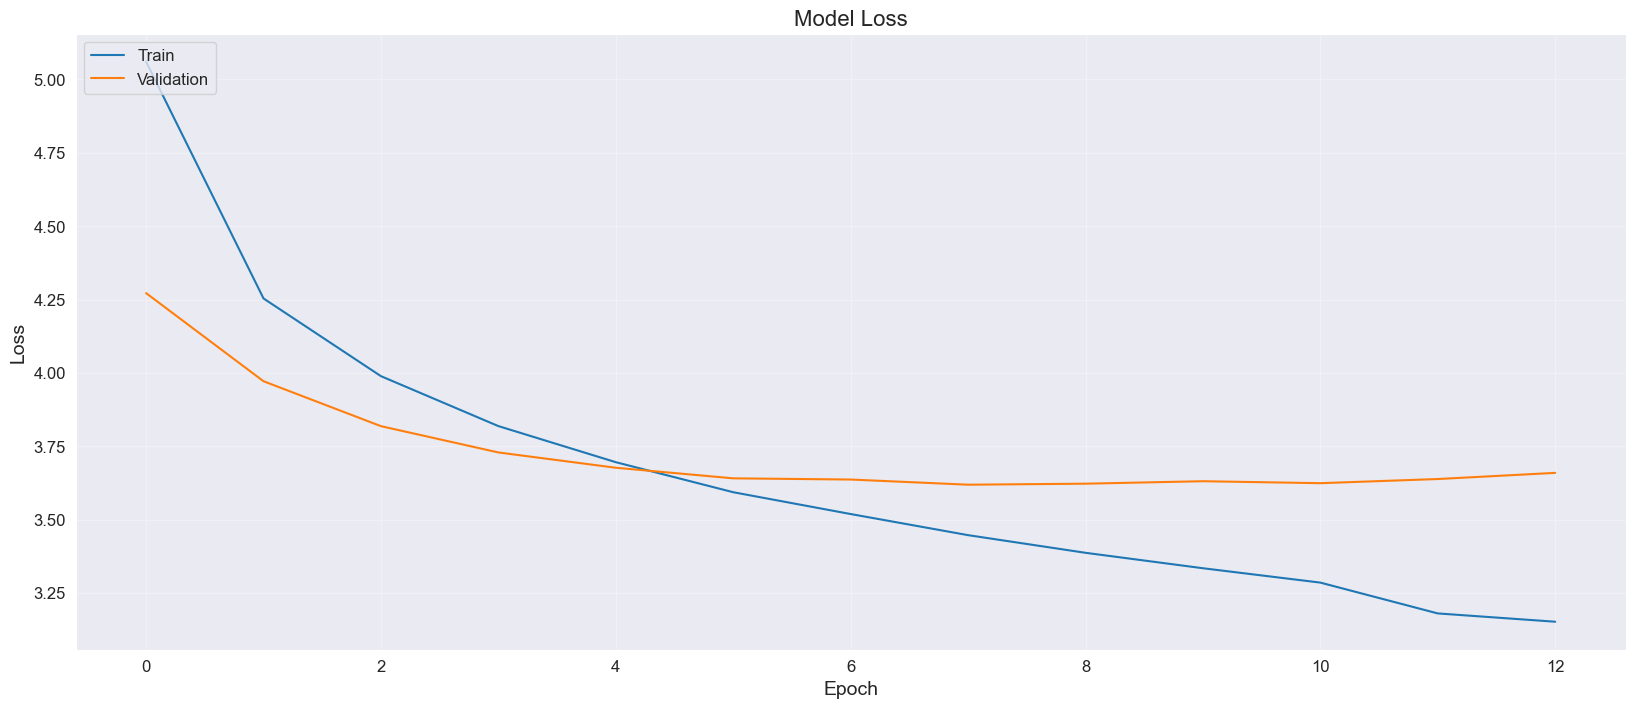

Training history saved to history.json

[Step 6] Evaluating model...


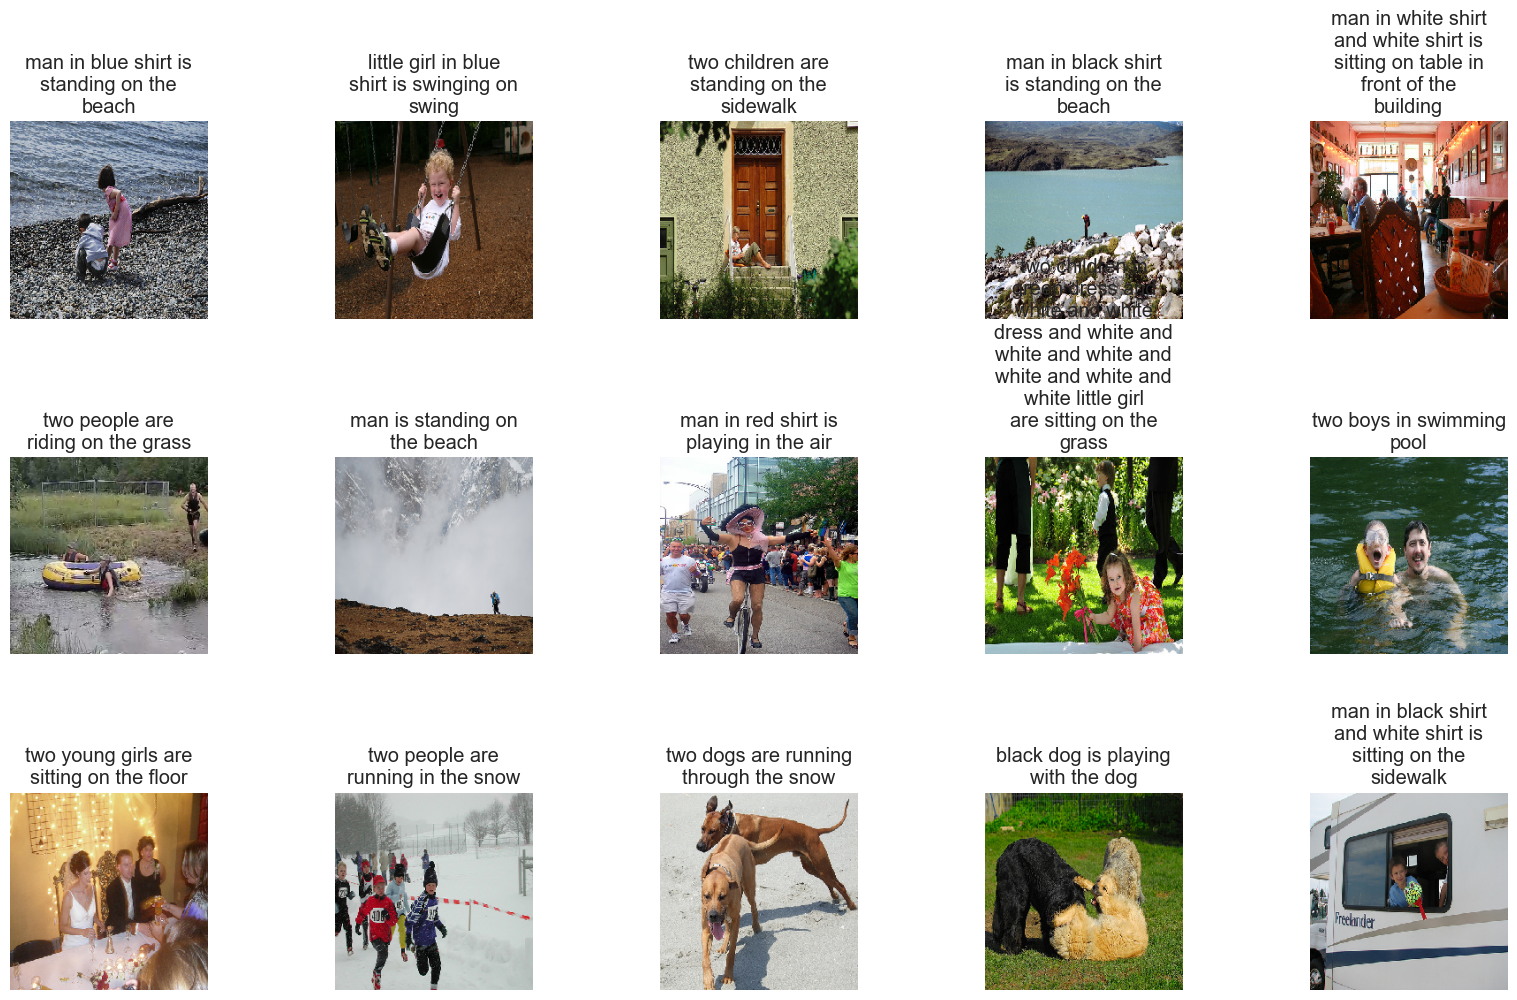


PIPELINE COMPLETED


In [13]:
"""
Complete Image Captioning System using CNN + LSTM
Dataset: Flickr8k
Architecture: DenseNet201 (Feature Extraction) + LSTM (Caption Generation)
"""

import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence, to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, GlobalAveragePooling2D, 
                                     Activation, Dropout, Flatten, Dense, Input, 
                                     Layer, Embedding, LSTM, add, Concatenate, 
                                     Reshape, concatenate, Bidirectional)
from tensorflow.keras.applications import VGG16, ResNet50, DenseNet201
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap
import pickle
import json

# Configuration
plt.rcParams['font.size'] = 12
sns.set_style("dark")
warnings.filterwarnings('ignore')

# ==============================================================================
# CONFIGURATION CLASS
# ==============================================================================
class Config:
    """Configuration parameters for the image captioning system"""
    def __init__(self):
        # Data paths
        self.IMAGE_PATH = './15k/Images' 
        self.CAPTION_FILE = './15k/captions.txt'
        
        # Model parameters
        self.IMG_SIZE = 224
        self.EMBEDDING_DIM = 256
        self.LSTM_UNITS = 256
        self.DENSE_UNITS = 128
        self.DROPOUT_RATE = 0.5
        
        # Training parameters
        self.BATCH_SIZE = 64
        self.EPOCHS = 50
        self.TRAIN_SPLIT = 0.85
        self.LEARNING_RATE = 0.001
        
        # Feature extraction
        self.FEATURE_VECTOR_SIZE = 1920  # DenseNet201 output
        
        # Callbacks
        self.PATIENCE_EARLY_STOP = 5
        self.PATIENCE_LR_REDUCE = 3
        self.LR_REDUCE_FACTOR = 0.2
        self.MIN_LR = 1e-8
        
        # Save paths
        self.MODEL_PATH = 'model.h5'
        self.TOKENIZER_PATH = 'tokenizer.pkl'
        self.FEATURES_PATH = 'features.pkl'
        self.HISTORY_PATH = 'history.json'

config = Config()

# ==============================================================================
# DATA LOADING AND PREPROCESSING
# ==============================================================================
class DataLoader:
    """Handles data loading and preprocessing"""
    
    @staticmethod
    def load_data(caption_file):
        """Load caption data from CSV file"""
        print("Loading caption data...")
        data = pd.read_csv(caption_file)
        print(f"Loaded {len(data)} image-caption pairs")
        print(f"Number of unique images: {data['image'].nunique()}")
        return data
    
    @staticmethod
    def read_image(path, img_size=224):
        """Read and preprocess a single image"""
        img = load_img(path, color_mode='rgb', target_size=(img_size, img_size))
        img = img_to_array(img)
        img = img / 255.0
        return img
    
    @staticmethod
    def display_images(df, n_images=15):
        """Display sample images with captions"""
        temp_df = df.sample(n_images).reset_index(drop=True)
        plt.figure(figsize=(20, 20))
        n = 0
        for i in range(n_images):
            n += 1
            plt.subplot(5, 5, n)
            plt.subplots_adjust(hspace=0.7, wspace=0.3)
            image = DataLoader.read_image(f"{config.IMAGE_PATH}/{temp_df.image[i]}")
            plt.imshow(image)
            plt.title("\n".join(wrap(temp_df.caption[i], 20)))
            plt.axis("off")
        plt.show()

# ==============================================================================
# TEXT PREPROCESSING
# ==============================================================================
class TextPreprocessor:
    """Handles text preprocessing and tokenization"""
    
    @staticmethod
    def preprocess_text(data):
        """Preprocess caption text"""
        print("Preprocessing captions...")
        
        # Convert to lowercase
        data['caption'] = data['caption'].apply(lambda x: x.lower())
        
        # Remove special characters and numbers
        data['caption'] = data['caption'].apply(lambda x: x.replace("[^A-Za-z]", ""))
        
        # Remove extra spaces
        data['caption'] = data['caption'].apply(lambda x: x.replace("\s+", " "))
        
        # Remove single characters
        data['caption'] = data['caption'].apply(
            lambda x: " ".join([word for word in x.split() if len(word) > 1])
        )
        
        # Add start and end sequences
        data['caption'] = "startseq " + data['caption'] + " endseq"
        
        print("Text preprocessing completed")
        return data
    
    @staticmethod
    def create_tokenizer(captions):
        """Create and fit tokenizer on captions"""
        print("Creating tokenizer...")
        tokenizer = Tokenizer()
        tokenizer.fit_on_texts(captions)
        vocab_size = len(tokenizer.word_index) + 1
        print(f"Vocabulary size: {vocab_size}")
        return tokenizer, vocab_size
    
    @staticmethod
    def get_max_length(captions):
        """Get maximum caption length"""
        max_length = max(len(caption.split()) for caption in captions)
        print(f"Maximum caption length: {max_length}")
        return max_length
    
    @staticmethod
    def save_tokenizer(tokenizer, path):
        """Save tokenizer to disk"""
        with open(path, 'wb') as f:
            pickle.dump(tokenizer, f)
        print(f"Tokenizer saved to {path}")
    
    @staticmethod
    def load_tokenizer(path):
        """Load tokenizer from disk"""
        with open(path, 'rb') as f:
            tokenizer = pickle.load(f)
        return tokenizer

# ==============================================================================
# FEATURE EXTRACTION
# ==============================================================================
class FeatureExtractor:
    """Extract features from images using pre-trained CNN"""
    
    def __init__(self, model_name='DenseNet201'):
        """Initialize feature extractor"""
        self.model_name = model_name
        self.feature_extractor = self._build_feature_extractor()
    
    def _build_feature_extractor(self):
        """Build feature extraction model"""
        print(f"Building {self.model_name} feature extractor...")
        
        if self.model_name == 'DenseNet201':
            base_model = DenseNet201(weights='imagenet')
            # Use second to last layer (before classification)
            model = Model(inputs=base_model.input, 
                         outputs=base_model.layers[-2].output)
        elif self.model_name == 'ResNet50':
            base_model = ResNet50(weights='imagenet')
            model = Model(inputs=base_model.input, 
                         outputs=base_model.layers[-2].output)
        elif self.model_name == 'VGG16':
            base_model = VGG16(weights='imagenet')
            model = Model(inputs=base_model.input, 
                         outputs=base_model.layers[-2].output)
        else:
            raise ValueError(f"Unknown model: {self.model_name}")
        
        print("Feature extractor built successfully")
        return model
    
    def extract_features(self, image_list, image_path, img_size=224):
        """Extract features from all images"""
        print(f"Extracting features from {len(image_list)} images...")
        features = {}
        
        for image_name in tqdm(image_list):
            # Load image
            img = load_img(os.path.join(image_path, image_name), 
                          target_size=(img_size, img_size))
            img = img_to_array(img)
            img = img / 255.0
            img = np.expand_dims(img, axis=0)
            
            # Extract features
            feature = self.feature_extractor.predict(img, verbose=0)
            features[image_name] = feature
        
        print("Feature extraction completed")
        return features
    
    @staticmethod
    def save_features(features, path):
        """Save features to disk"""
        with open(path, 'wb') as f:
            pickle.dump(features, f)
        print(f"Features saved to {path}")
    
    @staticmethod
    def load_features(path):
        """Load features from disk"""
        with open(path, 'rb') as f:
            features = pickle.load(f)
        return features

# ==============================================================================
# DATA GENERATOR
# ==============================================================================
class CustomDataGenerator(Sequence):
    """Custom data generator for training"""
    
    def __init__(self, df, X_col, y_col, batch_size, directory, 
                 tokenizer, vocab_size, max_length, features, shuffle=True):
        """Initialize data generator"""
        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.directory = directory
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.features = features
        self.shuffle = shuffle
        self.n = len(self.df)
    
    def on_epoch_end(self):
        """Shuffle data at the end of each epoch"""
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)
    
    def __len__(self):
        """Number of batches per epoch"""
        return self.n // self.batch_size
    
    def __getitem__(self, index):
        """Get batch at index"""
        batch = self.df.iloc[index * self.batch_size:(index + 1) * self.batch_size, :]
        X1, X2, y = self.__get_data(batch)
        return (X1, X2), y
    
    def __get_data(self, batch):
        """Generate data for batch"""
        X1, X2, y = list(), list(), list()
        
        images = batch[self.X_col].tolist()
        
        for image in images:
            # Get image features
            feature = self.features[image][0]
            
            # Get captions for this image
            captions = batch.loc[batch[self.X_col] == image, self.y_col].tolist()
            
            for caption in captions:
                # Convert caption to sequence
                seq = self.tokenizer.texts_to_sequences([caption])[0]
                
                # Create input-output pairs for each word
                for i in range(1, len(seq)):
                    # Input sequence (all words up to i)
                    in_seq = seq[:i]
                    in_seq = pad_sequences([in_seq], maxlen=self.max_length)[0]
                    
                    # Output word (word at position i)
                    out_seq = to_categorical([seq[i]], num_classes=self.vocab_size)[0]
                    
                    X1.append(feature)
                    X2.append(in_seq)
                    y.append(out_seq)
        
        return np.array(X1), np.array(X2), np.array(y)

# ==============================================================================
# MODEL ARCHITECTURE
# ==============================================================================
class CaptionModel:
    """Image captioning model architecture"""
    
    def __init__(self, vocab_size, max_length, feature_size=1920, 
                 embedding_dim=256, lstm_units=256, dense_units=128, 
                 dropout_rate=0.5):
        """Initialize model parameters"""
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.feature_size = feature_size
        self.embedding_dim = embedding_dim
        self.lstm_units = lstm_units
        self.dense_units = dense_units
        self.dropout_rate = dropout_rate
        self.model = None
    
    def build_model(self):
        """Build the caption generation model"""
        print("Building caption model...")
        
        # Image feature input
        input1 = Input(shape=(self.feature_size,))
        img_features = Dense(self.embedding_dim, activation='relu')(input1)
        img_features_reshaped = Reshape((1, self.embedding_dim))(img_features)
        
        # Text sequence input
        input2 = Input(shape=(self.max_length,))
        sentence_features = Embedding(self.vocab_size, self.embedding_dim, 
                                     mask_zero=False)(input2)
        
        # Merge image and text features
        merged = concatenate([img_features_reshaped, sentence_features], axis=1)
        
        # LSTM layer
        sentence_features = LSTM(self.lstm_units)(merged)
        x = Dropout(self.dropout_rate)(sentence_features)
        
        # Add image features (skip connection)
        x = add([x, img_features])
        
        # Dense layers
        x = Dense(self.dense_units, activation='relu')(x)
        x = Dropout(self.dropout_rate)(x)
        
        # Output layer
        output = Dense(self.vocab_size, activation='softmax')(x)
        
        # Create model
        self.model = Model(inputs=[input1, input2], outputs=output)
        
        print("Model built successfully")
        return self.model
    
    def compile_model(self, learning_rate=0.001):
        """Compile the model"""
        self.model.compile(
            loss='categorical_crossentropy',
            optimizer=Adam(learning_rate=learning_rate)
        )
        print("Model compiled")
    
    def summary(self):
        """Print model summary"""
        return self.model.summary()
    
    def plot_model_architecture(self, save_path='model_architecture.png'):
        """Plot and save model architecture"""
        plot_model(self.model, to_file=save_path, show_shapes=True, 
                  show_layer_names=True)
        print(f"Model architecture saved to {save_path}")

# ==============================================================================
# TRAINING
# ==============================================================================
class ModelTrainer:
    """Handles model training"""
    
    def __init__(self, model, config):
        """Initialize trainer"""
        self.model = model
        self.config = config
        self.history = None
    
    def get_callbacks(self):
        """Create training callbacks"""
        callbacks = []
        
        # Model checkpoint
        checkpoint = ModelCheckpoint(
            self.config.MODEL_PATH,
            monitor='val_loss',
            mode='min',
            save_best_only=True,
            verbose=1
        )
        callbacks.append(checkpoint)
        
        # Early stopping
        early_stop = EarlyStopping(
            monitor='val_loss',
            min_delta=0,
            patience=self.config.PATIENCE_EARLY_STOP,
            verbose=1,
            restore_best_weights=True
        )
        callbacks.append(early_stop)
        
        # Learning rate reduction
        lr_reduce = ReduceLROnPlateau(
            monitor='val_loss',
            patience=self.config.PATIENCE_LR_REDUCE,
            verbose=1,
            factor=self.config.LR_REDUCE_FACTOR,
            min_lr=self.config.MIN_LR
        )
        callbacks.append(lr_reduce)
        
        return callbacks
    
    def train(self, train_generator, val_generator, epochs=50):
        """Train the model"""
        print("Starting training...")
        
        callbacks = self.get_callbacks()
        
        self.history = self.model.fit(
            train_generator,
            epochs=epochs,
            validation_data=val_generator,
            callbacks=callbacks,
            verbose=1
        )
        
        print("Training completed")
        return self.history
    
    def plot_history(self):
        """Plot training history"""
        plt.figure(figsize=(20, 8))
        plt.plot(self.history.history['loss'])
        plt.plot(self.history.history['val_loss'])
        plt.title('Model Loss', fontsize=16)
        plt.ylabel('Loss', fontsize=14)
        plt.xlabel('Epoch', fontsize=14)
        plt.legend(['Train', 'Validation'], loc='upper left', fontsize=12)
        plt.grid(True, alpha=0.3)
        plt.show()
    
    def save_history(self, path):
        """Save training history"""
        with open(path, 'w') as f:
            json.dump(self.history.history, f)
        print(f"Training history saved to {path}")

# ==============================================================================
# INFERENCE
# ==============================================================================
class CaptionGenerator:
    """Generate captions for images"""
    
    def __init__(self, model, tokenizer, max_length, features):
        """Initialize caption generator"""
        self.model = model
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.features = features
    
    def idx_to_word(self, integer):
        """Convert index to word"""
        for word, index in self.tokenizer.word_index.items():
            if index == integer:
                return word
        return None
    
    def generate_caption(self, image_name):
        """Generate caption for an image"""
        # Get image features
        feature = self.features[image_name]
        
        # Start with 'startseq'
        in_text = "startseq"
        
        # Generate caption word by word
        for i in range(self.max_length):
            # Convert text to sequence
            sequence = self.tokenizer.texts_to_sequences([in_text])[0]
            sequence = pad_sequences([sequence], maxlen=self.max_length)
            
            # Predict next word
            y_pred = self.model.predict([feature, sequence], verbose=0)
            y_pred = np.argmax(y_pred)
            
            # Convert index to word
            word = self.idx_to_word(y_pred)
            
            if word is None:
                break
            
            # Add word to caption
            in_text += " " + word
            
            # Stop if end sequence is generated
            if word == 'endseq':
                break
        
        return in_text
    
    def generate_captions_for_dataset(self, df, image_col='image'):
        """Generate captions for all images in dataset"""
        captions = []
        
        for image_name in tqdm(df[image_col].unique()):
            caption = self.generate_caption(image_name)
            captions.append({'image': image_name, 'generated_caption': caption})
        
        return pd.DataFrame(captions)
    
    def display_predictions(self, df, image_path, n_samples=15):
        """Display images with generated captions"""
        samples = df.sample(min(n_samples, len(df))).reset_index(drop=True)
        
        plt.figure(figsize=(20, 20))
        for i in range(len(samples)):
            plt.subplot(5, 5, i + 1)
            plt.subplots_adjust(hspace=0.7, wspace=0.3)
            
            # Load and display image
            img = load_img(os.path.join(image_path, samples.iloc[i]['image']), 
                          target_size=(224, 224))
            plt.imshow(img)
            
            # Display generated caption
            caption = samples.iloc[i]['generated_caption']
            caption = caption.replace('startseq', '').replace('endseq', '').strip()
            plt.title("\n".join(wrap(caption, 20)))
            plt.axis("off")
        
        plt.show()

# ==============================================================================
# MAIN PIPELINE
# ==============================================================================
class ImageCaptioningPipeline:
    """Complete pipeline for image captioning"""
    
    def __init__(self, config):
        """Initialize pipeline"""
        self.config = config
        self.data = None
        self.tokenizer = None
        self.vocab_size = None
        self.max_length = None
        self.features = None
        self.model = None
        self.train_data = None
        self.val_data = None
    
    def load_and_preprocess_data(self):
        """Load and preprocess data"""
        # Load data
        loader = DataLoader()
        self.data = loader.load_data(self.config.CAPTION_FILE)
        
        # Preprocess text
        preprocessor = TextPreprocessor()
        self.data = preprocessor.preprocess_text(self.data)
        
        # Create tokenizer
        captions = self.data['caption'].tolist()
        self.tokenizer, self.vocab_size = preprocessor.create_tokenizer(captions)
        self.max_length = preprocessor.get_max_length(captions)
        
        # Save tokenizer
        preprocessor.save_tokenizer(self.tokenizer, self.config.TOKENIZER_PATH)
        
        return self.data
    
    def extract_features(self):
        """Extract features from images"""
        extractor = FeatureExtractor(model_name='DenseNet201')
        image_list = self.data['image'].unique().tolist()
        self.features = extractor.extract_features(
            image_list, 
            self.config.IMAGE_PATH, 
            self.config.IMG_SIZE
        )
        
        # Save features
        extractor.save_features(self.features, self.config.FEATURES_PATH)
        
        return self.features
    
    def split_data(self):
        """Split data into train and validation sets"""
        images = self.data['image'].unique().tolist()
        n_images = len(images)
        split_idx = round(self.config.TRAIN_SPLIT * n_images)
        
        train_images = images[:split_idx]
        val_images = images[split_idx:]
        
        self.train_data = self.data[self.data['image'].isin(train_images)]
        self.val_data = self.data[self.data['image'].isin(val_images)]
        
        self.train_data = self.train_data.reset_index(drop=True)
        self.val_data = self.val_data.reset_index(drop=True)
        
        print(f"Train set: {len(self.train_data)} samples")
        print(f"Validation set: {len(self.val_data)} samples")
        
        return self.train_data, self.val_data
    
    def build_and_compile_model(self):
        """Build and compile model"""
        caption_model = CaptionModel(
            vocab_size=self.vocab_size,
            max_length=self.max_length,
            feature_size=self.config.FEATURE_VECTOR_SIZE,
            embedding_dim=self.config.EMBEDDING_DIM,
            lstm_units=self.config.LSTM_UNITS,
            dense_units=self.config.DENSE_UNITS,
            dropout_rate=self.config.DROPOUT_RATE
        )
        
        self.model = caption_model.build_model()
        caption_model.compile_model(learning_rate=self.config.LEARNING_RATE)
        caption_model.summary()
        
        return self.model
    
    def train_model(self):
        """Train the model"""
        # Create data generators
        train_generator = CustomDataGenerator(
            df=self.train_data,
            X_col='image',
            y_col='caption',
            batch_size=self.config.BATCH_SIZE,
            directory=self.config.IMAGE_PATH,
            tokenizer=self.tokenizer,
            vocab_size=self.vocab_size,
            max_length=self.max_length,
            features=self.features
        )
        
        val_generator = CustomDataGenerator(
            df=self.val_data,
            X_col='image',
            y_col='caption',
            batch_size=self.config.BATCH_SIZE,
            directory=self.config.IMAGE_PATH,
            tokenizer=self.tokenizer,
            vocab_size=self.vocab_size,
            max_length=self.max_length,
            features=self.features
        )
        
        # Train model
        trainer = ModelTrainer(self.model, self.config)
        history = trainer.train(
            train_generator, 
            val_generator, 
            epochs=self.config.EPOCHS
        )
        
        # Plot and save history
        trainer.plot_history()
        trainer.save_history(self.config.HISTORY_PATH)
        
        return history
    
    def evaluate_model(self, n_samples=15):
        """Evaluate model on validation set"""
        generator = CaptionGenerator(
            model=self.model,
            tokenizer=self.tokenizer,
            max_length=self.max_length,
            features=self.features
        )
        
        # Generate captions
        val_samples = self.val_data.sample(n_samples).reset_index(drop=True)
        for idx, row in val_samples.iterrows():
            caption = generator.generate_caption(row['image'])
            val_samples.at[idx, 'generated_caption'] = caption
        
        # Display results
        generator.display_predictions(
            val_samples, 
            self.config.IMAGE_PATH, 
            n_samples
        )
        
        return val_samples
    
    def run_complete_pipeline(self):
        """Run the complete pipeline"""
        print("="*80)
        print("IMAGE CAPTIONING PIPELINE")
        print("="*80)
        
        # Step 1: Load and preprocess data
        print("\n[Step 1] Loading and preprocessing data...")
        self.load_and_preprocess_data()
        
        # Step 2: Extract features
        print("\n[Step 2] Extracting image features...")
        self.extract_features()
        
        # Step 3: Split data
        print("\n[Step 3] Splitting data...")
        self.split_data()
        
        # Step 4: Build model
        print("\n[Step 4] Building model...")
        self.build_and_compile_model()
        
        # Step 5: Train model
        print("\n[Step 5] Training model...")
        self.train_model()
        
        # Step 6: Evaluate model
        print("\n[Step 6] Evaluating model...")
        self.evaluate_model()
        
        print("\n" + "="*80)
        print("PIPELINE COMPLETED")
        print("="*80)

# ==============================================================================
# USAGE EXAMPLE
# ==============================================================================
if __name__ == "__main__":
    # Initialize configuration
    config = Config()
    
    # Create and run pipeline
    pipeline = ImageCaptioningPipeline(config)
    pipeline.run_complete_pipeline()
    
    # For inference on new images:
    # generator = CaptionGenerator(
    #     model=pipeline.model,
    #     tokenizer=pipeline.tokenizer,
    #     max_length=pipeline.max_length,
    #     features=pipeline.features
    # )
    # caption = generator.generate_caption('test_image.jpg')
    # print(caption)

# ACCURACY CHEACKING

In [17]:
"""
Accuracy and Evaluation Metrics for Image Captioning
Includes: BLEU, METEOR, ROUGE-L, CIDEr, and Word Accuracy
"""
!pip install rouge-score


import numpy as np
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu, SmoothingFunction
from nltk.translate.meteor_score import meteor_score
from rouge_score import rouge_scorer
import nltk
from collections import Counter

# Download required NLTK data
try:
    nltk.download('wordnet', quiet=True)
    nltk.download('omw-1.4', quiet=True)
except:
    pass

# ==============================================================================
# EVALUATION METRICS CLASS
# ==============================================================================
class CaptionEvaluator:
    """Comprehensive evaluation metrics for image captioning"""
    
    def __init__(self):
        """Initialize evaluator"""
        self.smoothing = SmoothingFunction()
        self.rouge_scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
    
    def preprocess_caption(self, caption):
        """Clean and preprocess caption"""
        caption = caption.lower()
        caption = caption.replace('startseq', '').replace('endseq', '').strip()
        return caption
    
    def calculate_bleu(self, reference, hypothesis, weights=(0.25, 0.25, 0.25, 0.25)):
        """
        Calculate BLEU score (Bilingual Evaluation Understudy)
        Measures n-gram overlap between reference and hypothesis
        
        Args:
            reference: Ground truth caption (string or list of words)
            hypothesis: Generated caption (string or list of words)
            weights: Weights for BLEU-1, BLEU-2, BLEU-3, BLEU-4
        
        Returns:
            BLEU score (0 to 1)
        """
        # Convert to list of words if string
        if isinstance(reference, str):
            reference = reference.split()
        if isinstance(hypothesis, str):
            hypothesis = hypothesis.split()
        
        # BLEU expects reference as list of references
        reference = [reference]
        
        try:
            score = sentence_bleu(reference, hypothesis, 
                                weights=weights,
                                smoothing_function=self.smoothing.method1)
        except:
            score = 0.0
        
        return score
    
    def calculate_bleu_scores(self, reference, hypothesis):
        """
        Calculate BLEU-1, BLEU-2, BLEU-3, BLEU-4 scores
        
        Returns:
            Dictionary with individual BLEU scores
        """
        if isinstance(reference, str):
            reference = reference.split()
        if isinstance(hypothesis, str):
            hypothesis = hypothesis.split()
        
        reference = [reference]
        
        scores = {}
        scores['BLEU-1'] = sentence_bleu(reference, hypothesis, weights=(1, 0, 0, 0),
                                        smoothing_function=self.smoothing.method1)
        scores['BLEU-2'] = sentence_bleu(reference, hypothesis, weights=(0.5, 0.5, 0, 0),
                                        smoothing_function=self.smoothing.method1)
        scores['BLEU-3'] = sentence_bleu(reference, hypothesis, weights=(0.33, 0.33, 0.33, 0),
                                        smoothing_function=self.smoothing.method1)
        scores['BLEU-4'] = sentence_bleu(reference, hypothesis, weights=(0.25, 0.25, 0.25, 0.25),
                                        smoothing_function=self.smoothing.method1)
        
        return scores
    
    def calculate_meteor(self, reference, hypothesis):
        """
        Calculate METEOR score
        Considers synonyms, stemming, and word order
        
        Returns:
            METEOR score (0 to 1)
        """
        reference = self.preprocess_caption(reference)
        hypothesis = self.preprocess_caption(hypothesis)
        
        try:
            score = meteor_score([reference], hypothesis)
        except:
            score = 0.0
        
        return score
    
    def calculate_rouge_l(self, reference, hypothesis):
        """
        Calculate ROUGE-L score
        Measures longest common subsequence
        
        Returns:
            ROUGE-L F1 score (0 to 1)
        """
        reference = self.preprocess_caption(reference)
        hypothesis = self.preprocess_caption(hypothesis)
        
        try:
            scores = self.rouge_scorer.score(reference, hypothesis)
            score = scores['rougeL'].fmeasure
        except:
            score = 0.0
        
        return score
    
    def calculate_word_accuracy(self, reference, hypothesis):
        """
        Calculate word-level accuracy
        Percentage of words correctly predicted
        
        Returns:
            Word accuracy (0 to 1)
        """
        ref_words = set(self.preprocess_caption(reference).split())
        hyp_words = set(self.preprocess_caption(hypothesis).split())
        
        if len(ref_words) == 0:
            return 0.0
        
        correct = len(ref_words.intersection(hyp_words))
        accuracy = correct / len(ref_words)
        
        return accuracy
    
    def calculate_exact_match(self, reference, hypothesis):
        """
        Calculate exact match accuracy
        
        Returns:
            1 if exact match, 0 otherwise
        """
        ref = self.preprocess_caption(reference)
        hyp = self.preprocess_caption(hypothesis)
        
        return 1.0 if ref == hyp else 0.0
    
    def evaluate_single_caption(self, reference, hypothesis):
        """
        Evaluate a single caption with all metrics
        
        Returns:
            Dictionary of all metric scores
        """
        reference = self.preprocess_caption(reference)
        hypothesis = self.preprocess_caption(hypothesis)
        
        results = {}
        
        # BLEU scores
        bleu_scores = self.calculate_bleu_scores(reference, hypothesis)
        results.update(bleu_scores)
        
        # METEOR
        results['METEOR'] = self.calculate_meteor(reference, hypothesis)
        
        # ROUGE-L
        results['ROUGE-L'] = self.calculate_rouge_l(reference, hypothesis)
        
        # Word Accuracy
        results['Word_Accuracy'] = self.calculate_word_accuracy(reference, hypothesis)
        
        # Exact Match
        results['Exact_Match'] = self.calculate_exact_match(reference, hypothesis)
        
        return results
    
    def evaluate_dataset(self, references, hypotheses):
        """
        Evaluate entire dataset
        
        Args:
            references: List of reference captions
            hypotheses: List of generated captions
        
        Returns:
            Dictionary with average scores and per-sample scores
        """
        assert len(references) == len(hypotheses), "Lengths must match"
        
        all_scores = []
        
        for ref, hyp in zip(references, hypotheses):
            scores = self.evaluate_single_caption(ref, hyp)
            all_scores.append(scores)
        
        # Calculate averages
        avg_scores = {}
        metrics = all_scores[0].keys()
        
        for metric in metrics:
            values = [s[metric] for s in all_scores]
            avg_scores[f'{metric}_mean'] = np.mean(values)
            avg_scores[f'{metric}_std'] = np.std(values)
        
        return {
            'average_scores': avg_scores,
            'individual_scores': all_scores
        }
    
    def print_evaluation_report(self, results):
        """
        Print formatted evaluation report
        """
        print("\n" + "="*80)
        print("EVALUATION REPORT")
        print("="*80)
        
        avg_scores = results['average_scores']
        
        print("\nBLEU Scores:")
        print(f"  BLEU-1: {avg_scores['BLEU-1_mean']:.4f} (±{avg_scores['BLEU-1_std']:.4f})")
        print(f"  BLEU-2: {avg_scores['BLEU-2_mean']:.4f} (±{avg_scores['BLEU-2_std']:.4f})")
        print(f"  BLEU-3: {avg_scores['BLEU-3_mean']:.4f} (±{avg_scores['BLEU-3_std']:.4f})")
        print(f"  BLEU-4: {avg_scores['BLEU-4_mean']:.4f} (±{avg_scores['BLEU-4_std']:.4f})")
        
        print("\nOther Metrics:")
        print(f"  METEOR:        {avg_scores['METEOR_mean']:.4f} (±{avg_scores['METEOR_std']:.4f})")
        print(f"  ROUGE-L:       {avg_scores['ROUGE-L_mean']:.4f} (±{avg_scores['ROUGE-L_std']:.4f})")
        print(f"  Word Accuracy: {avg_scores['Word_Accuracy_mean']:.4f} (±{avg_scores['Word_Accuracy_std']:.4f})")
        print(f"  Exact Match:   {avg_scores['Exact_Match_mean']:.4f} (±{avg_scores['Exact_Match_std']:.4f})")
        
        print("\n" + "="*80)


# ==============================================================================
# ADD TO YOUR EXISTING PIPELINE
# ==============================================================================

# Add this method to your CaptionGenerator class:
def evaluate_with_metrics(self, df, image_col='image', caption_col='caption', n_samples=None):
    """
    Generate captions and calculate accuracy metrics
    
    Args:
        df: DataFrame with images and reference captions
        image_col: Column name for image filenames
        caption_col: Column name for reference captions
        n_samples: Number of samples to evaluate (None for all)
    
    Returns:
        DataFrame with results and evaluation metrics
    """
    from tqdm import tqdm
    import pandas as pd
    
    # Sample if requested
    if n_samples:
        df = df.sample(min(n_samples, len(df))).reset_index(drop=True)
    
    # Get unique images (one caption per image)
    df_unique = df.groupby(image_col).first().reset_index()
    
    results = []
    
    print(f"Evaluating {len(df_unique)} images...")
    for idx, row in tqdm(df_unique.iterrows(), total=len(df_unique)):
        # Generate caption
        generated = self.generate_caption(row[image_col])
        generated_clean = generated.replace('startseq', '').replace('endseq', '').strip()
        
        # Get reference caption
        reference = row[caption_col]
        
        results.append({
            'image': row[image_col],
            'reference_caption': reference,
            'generated_caption': generated_clean
        })
    
    results_df = pd.DataFrame(results)
    
    # Calculate metrics
    print("\nCalculating evaluation metrics...")
    evaluator = CaptionEvaluator()
    
    evaluation_results = evaluator.evaluate_dataset(
        results_df['reference_caption'].tolist(),
        results_df['generated_caption'].tolist()
    )
    
    # Print report
    evaluator.print_evaluation_report(evaluation_results)
    
    # Add individual scores to dataframe
    for idx, scores in enumerate(evaluation_results['individual_scores']):
        for metric, value in scores.items():
            results_df.at[idx, metric] = value
    
    return results_df, evaluation_results


# ==============================================================================
# USAGE EXAMPLE
# ==============================================================================
if __name__ == "__main__":
    """
    Example usage with your existing pipeline:
    
    # After training your model:
    
    # 1. Create caption generator
    generator = CaptionGenerator(
        model=pipeline.model,
        tokenizer=pipeline.tokenizer,
        max_length=pipeline.max_length,
        features=pipeline.features
    )
    
    # 2. Evaluate on validation set
    results_df, evaluation = generator.evaluate_with_metrics(
        df=pipeline.val_data,
        image_col='image',
        caption_col='caption',
        n_samples=100  # Evaluate on 100 samples
    )
    
    # 3. View results
    print(results_df.head())
    
    # 4. Save results
    results_df.to_csv('evaluation_results.csv', index=False)
    
    # 5. Get individual metrics
    print(f"Average BLEU-4: {results_df['BLEU-4'].mean():.4f}")
    print(f"Average METEOR: {results_df['METEOR'].mean():.4f}")
    print(f"Average Word Accuracy: {results_df['Word_Accuracy'].mean():.4f}")
    """
    
    # Example with sample data
    evaluator = CaptionEvaluator()
    
    # Test single caption
    reference = "a dog is running in the park"
    hypothesis = "a dog running in a park"
    
    scores = evaluator.evaluate_single_caption(reference, hypothesis)
    print("\nSingle Caption Evaluation:")
    for metric, score in scores.items():
        print(f"{metric}: {score:.4f}")
    
    # Test multiple captions
    references = [
        "a dog is running in the park",
        "a cat sitting on a table",
        "children playing with a ball"
    ]
    
    hypotheses = [
        "a dog running in a park",
        "a cat on the table",
        "kids playing ball"
    ]
    
    results = evaluator.evaluate_dataset(references, hypotheses)
    evaluator.print_evaluation_report(results)

  DEPRECATION: Building 'rouge-score' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'rouge-score'. Discussion can be found at https://github.com/pypa/pip/issues/6334


  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24971 sha256=9e6b20d6dda3d2c57826905d60f528ae4a6ab6a0b7edf91e7770fa98a801c291
  Stored in directory: c:\users\prajwal\appdata\local\pip\cache\wheels\44\af\da\5ffc433e2786f0b1a9c6f458d5fb8f611d8eb332387f18698f
Successfully built rouge-score

Single Caption Evaluation:
BLEU-1: 0.7054
BLEU-2: 0.4887
BLEU-3: 0.1744
BLEU-4: 0.1093
METEOR: 0.0000
ROUGE-L: 0.7692
Word_Accuracy: 0.7143
Exact_Match: 0.0000

EVALUATION REPORT

BLEU Scores:
  BLEU-1: 0.5676 (±0.1606)
  BLEU-2: 0.3162 (±0.1651)
  BLEU-3: 0.1364 (±0.0418)
  BLEU-4: 0.0964 (±0.0191)

Other Metrics:
  METEOR:        0.0000 (±0.0000)
  ROUGE-L:       0.6655 (±0.1183)
  Word Accuracy: 0.6381 (±0.1720)
  Exact Match:   0.0000 (±0.0000)



# TESTING


IMAGE CAPTIONING - INFERENCE MODE

Choose testing mode:
1. Single image
2. Multiple images
3. Test folder
4. Interactive mode



Enter choice (1-4):  4



EXAMPLE 4: Interactive Image Captioning

Initializing Image Caption Predictor...
Loading model from model.h5...


✓ Model loaded successfully
Loading tokenizer from tokenizer.pkl...
✓ Tokenizer loaded successfully
✓ Vocabulary size: 8485
✓ Maximum caption length: 34
Building feature extractor (DenseNet201)...
✓ Feature extractor ready

PREDICTOR READY FOR INFERENCE

Enter image paths (or 'quit' to exit):



Image path:  reimagine.wepg



❌ Error: Image not found: reimagine.wepg



Image path:  reimagine.webp


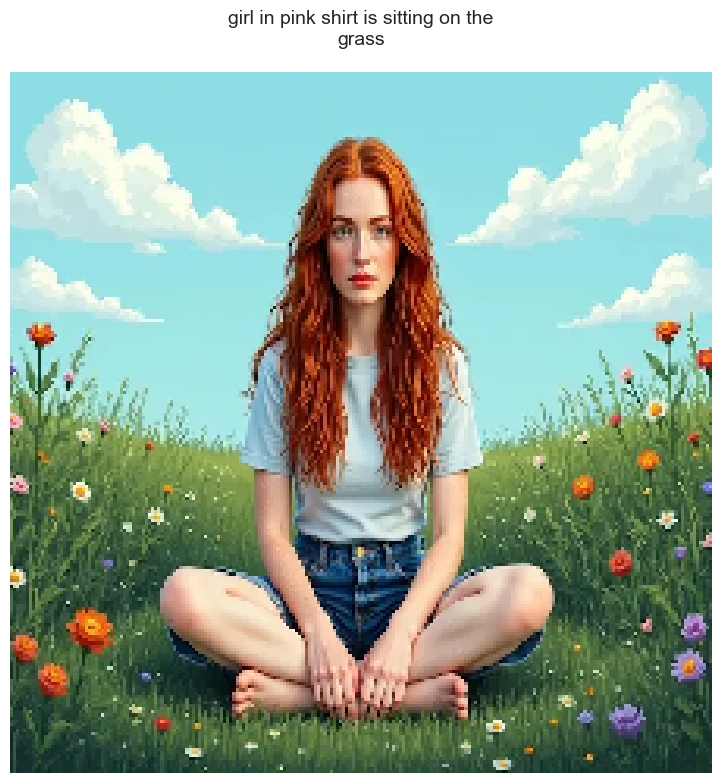


📝 Caption: girl in pink shirt is sitting on the grass



Image path:  exit



Exiting...


In [21]:
"""
Load Saved Image Captioning Model and Test on User Images
Supports single images, multiple images, and batch testing
"""

import numpy as np
import pandas as pd
import os
import pickle
import json
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from textwrap import wrap
import warnings
warnings.filterwarnings('ignore')

# ==============================================================================
# MODEL LOADER CLASS
# ==============================================================================
class ImageCaptionPredictor:
    """
    Load trained model and generate captions for new images
    """
    
    def __init__(self, model_path='model.h5', tokenizer_path='tokenizer.pkl', 
                 img_size=224, max_length=None):
        """
        Initialize predictor by loading saved model and tokenizer
        
        Args:
            model_path: Path to saved model (.h5 file)
            tokenizer_path: Path to saved tokenizer (.pkl file)
            img_size: Image size for preprocessing (default: 224)
            max_length: Maximum caption length (auto-detected if None)
        """
        print("Initializing Image Caption Predictor...")
        
        self.img_size = img_size
        self.model_path = model_path
        self.tokenizer_path = tokenizer_path
        
        # Load model
        print(f"Loading model from {model_path}...")
        self.model = load_model(model_path)
        print("✓ Model loaded successfully")
        
        # Load tokenizer
        print(f"Loading tokenizer from {tokenizer_path}...")
        with open(tokenizer_path, 'rb') as f:
            self.tokenizer = pickle.load(f)
        print("✓ Tokenizer loaded successfully")
        
        # Get vocabulary size
        self.vocab_size = len(self.tokenizer.word_index) + 1
        print(f"✓ Vocabulary size: {self.vocab_size}")
        
        # Set or detect max length
        if max_length is None:
            self.max_length = self._detect_max_length()
        else:
            self.max_length = max_length
        print(f"✓ Maximum caption length: {self.max_length}")
        
        # Build feature extractor
        print("Building feature extractor (DenseNet201)...")
        self.feature_extractor = self._build_feature_extractor()
        print("✓ Feature extractor ready")
        
        print("\n" + "="*60)
        print("PREDICTOR READY FOR INFERENCE")
        print("="*60 + "\n")
    
    def _detect_max_length(self):
        """Auto-detect max length from model input shape"""
        try:
            # Get input shape from model
            input_shapes = [inp.shape for inp in self.model.inputs]
            # Second input is text sequence
            max_len = input_shapes[1][1]
            return int(max_len)
        except:
            # Default fallback
            print("Warning: Could not auto-detect max_length, using default: 34")
            return 34
    
    def _build_feature_extractor(self):
        """Build DenseNet201 feature extractor"""
        base_model = DenseNet201(weights='imagenet')
        model = Model(inputs=base_model.input, 
                     outputs=base_model.layers[-2].output)
        return model
    
    def extract_features(self, image_path):
        """
        Extract features from a single image
        
        Args:
            image_path: Path to image file
        
        Returns:
            Feature vector (numpy array)
        """
        # Load and preprocess image
        img = load_img(image_path, target_size=(self.img_size, self.img_size))
        img = img_to_array(img)
        img = img / 255.0
        img = np.expand_dims(img, axis=0)
        
        # Extract features
        features = self.feature_extractor.predict(img, verbose=0)
        
        return features
    
    def idx_to_word(self, integer):
        """Convert word index to word"""
        for word, index in self.tokenizer.word_index.items():
            if index == integer:
                return word
        return None
    
    def generate_caption(self, image_path, show_image=False):
        """
        Generate caption for a single image
        
        Args:
            image_path: Path to image file
            show_image: Whether to display the image (default: False)
        
        Returns:
            Generated caption (string)
        """
        # Check if file exists
        if not os.path.exists(image_path):
            raise FileNotFoundError(f"Image not found: {image_path}")
        
        # Extract features
        feature = self.extract_features(image_path)
        
        # Start with 'startseq'
        in_text = "startseq"
        
        # Generate caption word by word
        for i in range(self.max_length):
            # Convert text to sequence
            sequence = self.tokenizer.texts_to_sequences([in_text])[0]
            sequence = pad_sequences([sequence], maxlen=self.max_length)
            
            # Predict next word
            y_pred = self.model.predict([feature, sequence], verbose=0)
            y_pred = np.argmax(y_pred)
            
            # Convert index to word
            word = self.idx_to_word(y_pred)
            
            if word is None:
                break
            
            # Add word to caption
            in_text += " " + word
            
            # Stop if end sequence is generated
            if word == 'endseq':
                break
        
        # Clean caption
        caption = in_text.replace('startseq', '').replace('endseq', '').strip()
        
        # Display image if requested
        if show_image:
            self.display_image_with_caption(image_path, caption)
        
        return caption
    
    def generate_captions_batch(self, image_paths, show_images=False):
        """
        Generate captions for multiple images
        
        Args:
            image_paths: List of image file paths
            show_images: Whether to display images (default: False)
        
        Returns:
            Dictionary mapping image paths to captions
        """
        results = {}
        
        print(f"Generating captions for {len(image_paths)} images...\n")
        
        for i, image_path in enumerate(image_paths, 1):
            try:
                print(f"[{i}/{len(image_paths)}] Processing: {os.path.basename(image_path)}")
                caption = self.generate_caption(image_path)
                results[image_path] = caption
                print(f"  Caption: {caption}\n")
            except Exception as e:
                print(f"  Error: {str(e)}\n")
                results[image_path] = None
        
        if show_images:
            self.display_multiple_images(results)
        
        return results
    
    def display_image_with_caption(self, image_path, caption, figsize=(10, 8)):
        """Display a single image with its caption"""
        plt.figure(figsize=figsize)
        img = load_img(image_path, target_size=(self.img_size, self.img_size))
        plt.imshow(img)
        plt.title("\n".join(wrap(caption, 40)), fontsize=14, pad=20)
        plt.axis('off')
        plt.tight_layout()
        plt.show()
    
    def display_multiple_images(self, results, images_per_row=3):
        """
        Display multiple images with their captions
        
        Args:
            results: Dictionary mapping image paths to captions
            images_per_row: Number of images per row (default: 3)
        """
        image_paths = list(results.keys())
        n_images = len(image_paths)
        
        # Calculate grid size
        n_rows = (n_images + images_per_row - 1) // images_per_row
        
        plt.figure(figsize=(5 * images_per_row, 5 * n_rows))
        
        for i, image_path in enumerate(image_paths, 1):
            caption = results[image_path]
            
            plt.subplot(n_rows, images_per_row, i)
            plt.subplots_adjust(hspace=0.4, wspace=0.3)
            
            try:
                img = load_img(image_path, target_size=(self.img_size, self.img_size))
                plt.imshow(img)
                
                if caption:
                    plt.title("\n".join(wrap(caption, 20)), fontsize=10)
                else:
                    plt.title("Error generating caption", fontsize=10, color='red')
            except:
                plt.text(0.5, 0.5, 'Image not found', 
                        ha='center', va='center', fontsize=12)
            
            plt.axis('off')
        
        plt.tight_layout()
        plt.show()
    
    def test_from_folder(self, folder_path, n_samples=None, show_images=True):
        """
        Test on all images in a folder
        
        Args:
            folder_path: Path to folder containing images
            n_samples: Number of images to test (None for all)
            show_images: Whether to display images
        
        Returns:
            DataFrame with results
        """
        # Get all image files
        image_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.gif']
        image_files = [f for f in os.listdir(folder_path) 
                      if os.path.splitext(f.lower())[1] in image_extensions]
        
        if not image_files:
            raise ValueError(f"No image files found in {folder_path}")
        
        # Sample if requested
        if n_samples:
            import random
            image_files = random.sample(image_files, min(n_samples, len(image_files)))
        
        # Generate full paths
        image_paths = [os.path.join(folder_path, f) for f in image_files]
        
        # Generate captions
        results = self.generate_captions_batch(image_paths, show_images=show_images)
        
        # Create dataframe
        df = pd.DataFrame([
            {'image': os.path.basename(path), 'caption': caption}
            for path, caption in results.items()
        ])
        
        return df
    
    def save_results(self, results, output_path='predictions.csv'):
        """
        Save prediction results to CSV
        
        Args:
            results: Dictionary or DataFrame with results
            output_path: Output file path
        """
        if isinstance(results, dict):
            df = pd.DataFrame([
                {'image': os.path.basename(path), 'caption': caption}
                for path, caption in results.items()
            ])
        else:
            df = results
        
        df.to_csv(output_path, index=False)
        print(f"\n✓ Results saved to {output_path}")


# ==============================================================================
# USAGE EXAMPLES
# ==============================================================================

def example_single_image():
    """Example: Test on a single image"""
    print("\n" + "="*60)
    print("EXAMPLE 1: Single Image Prediction")
    print("="*60 + "\n")
    
    # Initialize predictor
    predictor = ImageCaptionPredictor(
        model_path='model.h5',
        tokenizer_path='tokenizer.pkl'
    )
    
    # Test on single image
    image_path = 'test_image.jpg'  # Replace with your image path
    caption = predictor.generate_caption(image_path, show_image=True)
    
    print(f"\nGenerated Caption: {caption}")


def example_multiple_images():
    """Example: Test on multiple images"""
    print("\n" + "="*60)
    print("EXAMPLE 2: Multiple Images Prediction")
    print("="*60 + "\n")
    
    # Initialize predictor
    predictor = ImageCaptionPredictor(
        model_path='model.h5',
        tokenizer_path='tokenizer.pkl'
    )
    
    # Test on multiple images
    image_paths = [
        'image1.jpg',
        'image2.jpg',
        'image3.jpg'
    ]
    
    results = predictor.generate_captions_batch(image_paths, show_images=True)
    
    # Save results
    predictor.save_results(results, 'predictions.csv')


def example_test_folder():
    """Example: Test on all images in a folder"""
    print("\n" + "="*60)
    print("EXAMPLE 3: Folder Testing")
    print("="*60 + "\n")
    
    # Initialize predictor
    predictor = ImageCaptionPredictor(
        model_path='model.h5',
        tokenizer_path='tokenizer.pkl'
    )
    
    # Test on folder
    results_df = predictor.test_from_folder(
        folder_path='test_images/',
        n_samples=10,  # Test on 10 random images
        show_images=True
    )
    
    print("\nResults:")
    print(results_df)
    
    # Save results
    results_df.to_csv('folder_predictions.csv', index=False)


def example_interactive():
    """Example: Interactive testing with user input"""
    print("\n" + "="*60)
    print("EXAMPLE 4: Interactive Image Captioning")
    print("="*60 + "\n")
    
    # Initialize predictor
    predictor = ImageCaptionPredictor(
        model_path='model.h5',
        tokenizer_path='tokenizer.pkl'
    )
    
    print("Enter image paths (or 'quit' to exit):\n")
    
    while True:
        image_path = input("Image path: ").strip()
        
        if image_path.lower() in ['quit', 'exit', 'q']:
            print("\nExiting...")
            break
        
        if not image_path:
            continue
        
        try:
            caption = predictor.generate_caption(image_path, show_image=True)
            print(f"\n📝 Caption: {caption}\n")
        except Exception as e:
            print(f"\n❌ Error: {str(e)}\n")


# ==============================================================================
# MAIN FUNCTION
# ==============================================================================

def main():
    """
    Main function - Choose your testing mode
    """
    
    print("\n" + "="*60)
    print("IMAGE CAPTIONING - INFERENCE MODE")
    print("="*60)
    print("\nChoose testing mode:")
    print("1. Single image")
    print("2. Multiple images")
    print("3. Test folder")
    print("4. Interactive mode")
    print("="*60 + "\n")
    
    choice = input("Enter choice (1-4): ").strip()
    
    if choice == '1':
        # Single image test
        predictor = ImageCaptionPredictor(
            model_path='model.h5',
            tokenizer_path='tokenizer.pkl'
        )
        
        image_path = input("\nEnter image path: ").strip()
        caption = predictor.generate_caption(image_path, show_image=True)
        print(f"\n📝 Generated Caption: {caption}")
    
    elif choice == '2':
        # Multiple images test
        predictor = ImageCaptionPredictor(
            model_path='model.h5',
            tokenizer_path='tokenizer.pkl'
        )
        
        print("\nEnter image paths (comma-separated):")
        paths_input = input().strip()
        image_paths = [p.strip() for p in paths_input.split(',')]
        
        results = predictor.generate_captions_batch(image_paths, show_images=True)
        
        save = input("\nSave results to CSV? (y/n): ").strip().lower()
        if save == 'y':
            predictor.save_results(results, 'predictions.csv')
    
    elif choice == '3':
        # Test folder
        predictor = ImageCaptionPredictor(
            model_path='model.h5',
            tokenizer_path='tokenizer.pkl'
        )
        
        folder_path = input("\nEnter folder path: ").strip()
        n_samples = input("Number of samples (press Enter for all): ").strip()
        n_samples = int(n_samples) if n_samples else None
        
        results_df = predictor.test_from_folder(
            folder_path, 
            n_samples=n_samples, 
            show_images=True
        )
        
        print("\nResults:")
        print(results_df)
        
        results_df.to_csv('folder_predictions.csv', index=False)
        print("\n✓ Results saved to 'folder_predictions.csv'")
    
    elif choice == '4':
        # Interactive mode
        example_interactive()
    
    else:
        print("Invalid choice!")


if __name__ == "__main__":
    # Run main function
    main()
    
    # Or run specific examples:
    # example_single_image()
    # example_multiple_images()
    # example_test_folder()
    # example_interactive()